# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [ ]:
!unzip summer2winter-yosemite.zip # can comment out after executing once

In [3]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [4]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [5]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

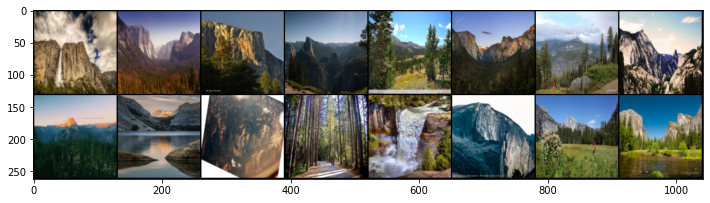

In [6]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

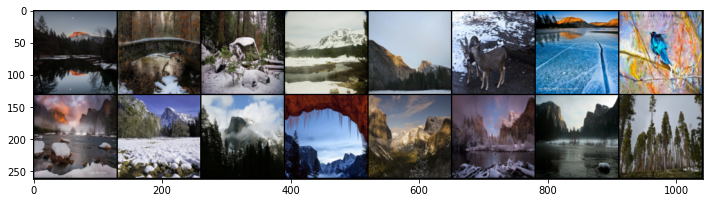

In [7]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9333)


In [9]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.8667)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs a prediction map with depth of one. Contrary to what the figure above indicates, the final output is not required to have a width and depth of one. In the original paper, the authors passed a 4x4 kernel with stride of 1 in the final convolutional layer. You should replicate that strategy.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 64x64x64
        self.conv2 = conv(conv_dim, conv_dim * 2, 4) #32x32x128
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4) #16x16x256
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4) #8x8x512
        self.conv5 = conv(conv_dim * 8, 1, 4, stride=1, batch_norm=False)
                          
        

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [13]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1) #I'm adding it to the original output
        
        return out_2
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [14]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [15]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
            
        self.res_blocks = nn.Sequential(*res_layers)    

        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        
        out = self.res_blocks(out) # no relu
        
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        
        out = F.tanh(self.deconv3(out)) # no relu, tanh instead

        return out

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into a painting.

In [16]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [17]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [18]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommend calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [19]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)
    

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)
    

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    reconstruction_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight * reconstruction_loss
    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [41]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.00025
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [29]:
# import save code
from helpers2 import save_samples, checkpoint

In [30]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_Y = G_XtoY(images_X)
        
        # 3. Compute the fake loss for D_X
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)
        
        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()
        


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
   
        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##
        fake_Y = G_XtoY(images_X)
        
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)
        
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
        checkpoint_every=1000
#         # Save the model parameters
        if epoch % checkpoint_every == 0:
          checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [42]:
n_epochs = 10000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/10000] | d_X_loss: 0.0473 | d_Y_loss: 0.0580 | g_total_loss: 4.2918
Epoch [   20/10000] | d_X_loss: 0.0532 | d_Y_loss: 0.1692 | g_total_loss: 4.2067
Epoch [   30/10000] | d_X_loss: 0.0673 | d_Y_loss: 0.0368 | g_total_loss: 4.0674
Epoch [   40/10000] | d_X_loss: 0.3237 | d_Y_loss: 0.0541 | g_total_loss: 3.7567
Epoch [   50/10000] | d_X_loss: 0.2418 | d_Y_loss: 0.1440 | g_total_loss: 3.9818
Epoch [   60/10000] | d_X_loss: 0.1721 | d_Y_loss: 0.1167 | g_total_loss: 3.2345
Epoch [   70/10000] | d_X_loss: 0.1448 | d_Y_loss: 0.0799 | g_total_loss: 4.2288
Epoch [   80/10000] | d_X_loss: 0.0755 | d_Y_loss: 0.0991 | g_total_loss: 4.2896
Epoch [   90/10000] | d_X_loss: 0.1653 | d_Y_loss: 0.1778 | g_total_loss: 4.9995


Epoch [  100/10000] | d_X_loss: 0.0554 | d_Y_loss: 0.0571 | g_total_loss: 4.2339


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/10000] | d_X_loss: 0.0670 | d_Y_loss: 0.1167 | g_total_loss: 4.4972
Epoch [  120/10000] | d_X_loss: 0.2361 | d_Y_loss: 0.0919 | g_total_loss: 5.0748
Epoch [  130/10000] | d_X_loss: 0.0849 | d_Y_loss: 0.0673 | g_total_loss: 4.9419
Epoch [  140/10000] | d_X_loss: 0.2277 | d_Y_loss: 0.5225 | g_total_loss: 5.5081
Epoch [  150/10000] | d_X_loss: 0.1530 | d_Y_loss: 0.1110 | g_total_loss: 4.5302
Epoch [  160/10000] | d_X_loss: 0.9445 | d_Y_loss: 0.0564 | g_total_loss: 3.0559
Epoch [  170/10000] | d_X_loss: 0.1816 | d_Y_loss: 0.0725 | g_total_loss: 4.2967
Epoch [  180/10000] | d_X_loss: 0.2675 | d_Y_loss: 0.2105 | g_total_loss: 5.0514
Epoch [  190/10000] | d_X_loss: 0.1864 | d_Y_loss: 0.0936 | g_total_loss: 3.6453


Epoch [  200/10000] | d_X_loss: 0.2015 | d_Y_loss: 0.0774 | g_total_loss: 4.2966


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/10000] | d_X_loss: 0.1511 | d_Y_loss: 0.1159 | g_total_loss: 4.2966
Epoch [  220/10000] | d_X_loss: 0.1430 | d_Y_loss: 0.1366 | g_total_loss: 4.7016
Epoch [  230/10000] | d_X_loss: 0.2750 | d_Y_loss: 0.1316 | g_total_loss: 4.3037
Epoch [  240/10000] | d_X_loss: 0.1441 | d_Y_loss: 0.0513 | g_total_loss: 4.0481
Epoch [  250/10000] | d_X_loss: 0.1184 | d_Y_loss: 0.0979 | g_total_loss: 4.1147
Epoch [  260/10000] | d_X_loss: 0.0745 | d_Y_loss: 0.0374 | g_total_loss: 4.0031
Epoch [  270/10000] | d_X_loss: 0.1790 | d_Y_loss: 0.0948 | g_total_loss: 3.7097
Epoch [  280/10000] | d_X_loss: 0.1052 | d_Y_loss: 0.0981 | g_total_loss: 4.1743
Epoch [  290/10000] | d_X_loss: 0.1488 | d_Y_loss: 0.1310 | g_total_loss: 3.8955


Epoch [  300/10000] | d_X_loss: 0.2204 | d_Y_loss: 0.1055 | g_total_loss: 3.4853


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/10000] | d_X_loss: 0.1575 | d_Y_loss: 0.2252 | g_total_loss: 3.1116
Epoch [  320/10000] | d_X_loss: 0.0594 | d_Y_loss: 0.0851 | g_total_loss: 3.8992
Epoch [  330/10000] | d_X_loss: 0.0976 | d_Y_loss: 0.0761 | g_total_loss: 4.0241
Epoch [  340/10000] | d_X_loss: 0.1060 | d_Y_loss: 0.1101 | g_total_loss: 3.6439
Epoch [  350/10000] | d_X_loss: 0.1010 | d_Y_loss: 0.0701 | g_total_loss: 3.4982
Epoch [  360/10000] | d_X_loss: 0.1068 | d_Y_loss: 0.0461 | g_total_loss: 3.8827
Epoch [  370/10000] | d_X_loss: 0.1565 | d_Y_loss: 0.0716 | g_total_loss: 5.1107
Epoch [  380/10000] | d_X_loss: 0.1048 | d_Y_loss: 0.1565 | g_total_loss: 3.6731
Epoch [  390/10000] | d_X_loss: 0.1484 | d_Y_loss: 0.2224 | g_total_loss: 4.1400


Epoch [  400/10000] | d_X_loss: 0.0745 | d_Y_loss: 0.0691 | g_total_loss: 4.5028


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/10000] | d_X_loss: 0.1322 | d_Y_loss: 0.0753 | g_total_loss: 3.5381
Epoch [  420/10000] | d_X_loss: 0.0663 | d_Y_loss: 0.5400 | g_total_loss: 3.1225
Epoch [  430/10000] | d_X_loss: 0.0785 | d_Y_loss: 0.2275 | g_total_loss: 3.7354
Epoch [  440/10000] | d_X_loss: 0.0655 | d_Y_loss: 0.0789 | g_total_loss: 4.5353
Epoch [  450/10000] | d_X_loss: 0.0703 | d_Y_loss: 0.0885 | g_total_loss: 3.9712
Epoch [  460/10000] | d_X_loss: 0.1676 | d_Y_loss: 0.0641 | g_total_loss: 4.1275
Epoch [  470/10000] | d_X_loss: 0.1277 | d_Y_loss: 0.0838 | g_total_loss: 4.7758
Epoch [  480/10000] | d_X_loss: 0.1338 | d_Y_loss: 0.1079 | g_total_loss: 3.9702
Epoch [  490/10000] | d_X_loss: 0.1628 | d_Y_loss: 0.0854 | g_total_loss: 4.0743


Epoch [  500/10000] | d_X_loss: 0.2885 | d_Y_loss: 0.0808 | g_total_loss: 5.8260


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/10000] | d_X_loss: 0.1748 | d_Y_loss: 0.2096 | g_total_loss: 3.0172
Epoch [  520/10000] | d_X_loss: 0.0714 | d_Y_loss: 0.0720 | g_total_loss: 4.4887
Epoch [  530/10000] | d_X_loss: 0.1066 | d_Y_loss: 0.1693 | g_total_loss: 4.5562
Epoch [  540/10000] | d_X_loss: 0.0868 | d_Y_loss: 0.0709 | g_total_loss: 4.4244
Epoch [  550/10000] | d_X_loss: 0.0710 | d_Y_loss: 0.0962 | g_total_loss: 4.4286
Epoch [  560/10000] | d_X_loss: 0.0951 | d_Y_loss: 0.1455 | g_total_loss: 4.9687
Epoch [  570/10000] | d_X_loss: 0.1498 | d_Y_loss: 0.0960 | g_total_loss: 3.6857
Epoch [  580/10000] | d_X_loss: 0.0561 | d_Y_loss: 0.0579 | g_total_loss: 4.6339
Epoch [  590/10000] | d_X_loss: 0.1553 | d_Y_loss: 0.1858 | g_total_loss: 4.0527


Epoch [  600/10000] | d_X_loss: 0.3116 | d_Y_loss: 0.0892 | g_total_loss: 3.1601


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/10000] | d_X_loss: 0.1203 | d_Y_loss: 0.1122 | g_total_loss: 4.9877
Epoch [  620/10000] | d_X_loss: 0.2043 | d_Y_loss: 0.0659 | g_total_loss: 3.5476
Epoch [  630/10000] | d_X_loss: 0.1059 | d_Y_loss: 0.0615 | g_total_loss: 3.9754
Epoch [  640/10000] | d_X_loss: 0.1081 | d_Y_loss: 0.0976 | g_total_loss: 3.3673
Epoch [  650/10000] | d_X_loss: 0.0830 | d_Y_loss: 0.0537 | g_total_loss: 4.1629
Epoch [  660/10000] | d_X_loss: 0.0728 | d_Y_loss: 0.2302 | g_total_loss: 5.0548
Epoch [  670/10000] | d_X_loss: 0.2421 | d_Y_loss: 0.0568 | g_total_loss: 6.6410
Epoch [  680/10000] | d_X_loss: 0.1668 | d_Y_loss: 0.0578 | g_total_loss: 3.2529
Epoch [  690/10000] | d_X_loss: 0.1679 | d_Y_loss: 0.1017 | g_total_loss: 3.9228


Epoch [  700/10000] | d_X_loss: 0.1544 | d_Y_loss: 0.0661 | g_total_loss: 4.5023


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/10000] | d_X_loss: 0.1069 | d_Y_loss: 0.0774 | g_total_loss: 3.9669
Epoch [  720/10000] | d_X_loss: 0.2111 | d_Y_loss: 0.1552 | g_total_loss: 4.3791
Epoch [  730/10000] | d_X_loss: 0.0709 | d_Y_loss: 0.1848 | g_total_loss: 3.3568
Epoch [  740/10000] | d_X_loss: 0.0668 | d_Y_loss: 0.2171 | g_total_loss: 4.7271
Epoch [  750/10000] | d_X_loss: 0.0954 | d_Y_loss: 0.0660 | g_total_loss: 4.1812
Epoch [  760/10000] | d_X_loss: 0.4586 | d_Y_loss: 0.0614 | g_total_loss: 3.7565
Epoch [  770/10000] | d_X_loss: 0.1438 | d_Y_loss: 0.2082 | g_total_loss: 3.3167
Epoch [  780/10000] | d_X_loss: 0.2056 | d_Y_loss: 0.0581 | g_total_loss: 3.6551
Epoch [  790/10000] | d_X_loss: 0.1239 | d_Y_loss: 0.0513 | g_total_loss: 4.1432


Epoch [  800/10000] | d_X_loss: 0.0651 | d_Y_loss: 0.1615 | g_total_loss: 5.2946


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/10000] | d_X_loss: 0.0582 | d_Y_loss: 0.0743 | g_total_loss: 4.2346
Epoch [  820/10000] | d_X_loss: 0.0544 | d_Y_loss: 0.0897 | g_total_loss: 4.1205
Epoch [  830/10000] | d_X_loss: 0.1220 | d_Y_loss: 0.0734 | g_total_loss: 3.7860
Epoch [  840/10000] | d_X_loss: 0.0927 | d_Y_loss: 0.1636 | g_total_loss: 4.5628
Epoch [  850/10000] | d_X_loss: 0.1808 | d_Y_loss: 0.1107 | g_total_loss: 4.2009
Epoch [  860/10000] | d_X_loss: 0.1098 | d_Y_loss: 0.1480 | g_total_loss: 3.5113
Epoch [  870/10000] | d_X_loss: 0.1048 | d_Y_loss: 0.0653 | g_total_loss: 4.3099
Epoch [  880/10000] | d_X_loss: 0.0423 | d_Y_loss: 0.0938 | g_total_loss: 4.1607
Epoch [  890/10000] | d_X_loss: 0.1993 | d_Y_loss: 0.0629 | g_total_loss: 4.3726


Epoch [  900/10000] | d_X_loss: 0.0967 | d_Y_loss: 0.0781 | g_total_loss: 4.3850


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/10000] | d_X_loss: 0.1802 | d_Y_loss: 0.1025 | g_total_loss: 4.4674
Epoch [  920/10000] | d_X_loss: 0.3244 | d_Y_loss: 0.0754 | g_total_loss: 3.4785
Epoch [  930/10000] | d_X_loss: 0.1122 | d_Y_loss: 0.0743 | g_total_loss: 3.5973
Epoch [  940/10000] | d_X_loss: 0.1537 | d_Y_loss: 0.0729 | g_total_loss: 3.6447
Epoch [  950/10000] | d_X_loss: 0.1428 | d_Y_loss: 0.1871 | g_total_loss: 5.8736
Epoch [  960/10000] | d_X_loss: 0.1047 | d_Y_loss: 0.1446 | g_total_loss: 4.6012
Epoch [  970/10000] | d_X_loss: 0.5711 | d_Y_loss: 0.0831 | g_total_loss: 3.4649
Epoch [  980/10000] | d_X_loss: 0.1615 | d_Y_loss: 0.0628 | g_total_loss: 4.0996
Epoch [  990/10000] | d_X_loss: 0.1096 | d_Y_loss: 0.2219 | g_total_loss: 4.6517


Epoch [ 1000/10000] | d_X_loss: 0.1275 | d_Y_loss: 0.1199 | g_total_loss: 4.3535


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/10000] | d_X_loss: 0.1866 | d_Y_loss: 0.0728 | g_total_loss: 3.8103
Epoch [ 1020/10000] | d_X_loss: 0.1672 | d_Y_loss: 0.1395 | g_total_loss: 3.0954
Epoch [ 1030/10000] | d_X_loss: 0.1150 | d_Y_loss: 0.2357 | g_total_loss: 4.9028
Epoch [ 1040/10000] | d_X_loss: 0.1006 | d_Y_loss: 0.1399 | g_total_loss: 3.7513
Epoch [ 1050/10000] | d_X_loss: 0.0673 | d_Y_loss: 0.0510 | g_total_loss: 4.4238
Epoch [ 1060/10000] | d_X_loss: 0.1077 | d_Y_loss: 0.0852 | g_total_loss: 4.1989
Epoch [ 1070/10000] | d_X_loss: 0.1279 | d_Y_loss: 0.1214 | g_total_loss: 4.1623
Epoch [ 1080/10000] | d_X_loss: 0.0494 | d_Y_loss: 0.0637 | g_total_loss: 3.9638
Epoch [ 1090/10000] | d_X_loss: 0.1650 | d_Y_loss: 0.1567 | g_total_loss: 4.9532


Epoch [ 1100/10000] | d_X_loss: 0.0928 | d_Y_loss: 0.2112 | g_total_loss: 4.9249


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/10000] | d_X_loss: 0.1258 | d_Y_loss: 1.7235 | g_total_loss: 3.8441
Epoch [ 1120/10000] | d_X_loss: 0.0468 | d_Y_loss: 0.7887 | g_total_loss: 3.2635
Epoch [ 1130/10000] | d_X_loss: 0.0676 | d_Y_loss: 0.4177 | g_total_loss: 3.2672
Epoch [ 1140/10000] | d_X_loss: 0.0454 | d_Y_loss: 0.5661 | g_total_loss: 3.4305
Epoch [ 1150/10000] | d_X_loss: 0.0673 | d_Y_loss: 0.4941 | g_total_loss: 3.2536
Epoch [ 1160/10000] | d_X_loss: 0.0808 | d_Y_loss: 0.4500 | g_total_loss: 3.7621
Epoch [ 1170/10000] | d_X_loss: 0.1327 | d_Y_loss: 0.4729 | g_total_loss: 4.1884
Epoch [ 1180/10000] | d_X_loss: 0.0351 | d_Y_loss: 0.4755 | g_total_loss: 3.2454
Epoch [ 1190/10000] | d_X_loss: 0.0644 | d_Y_loss: 0.4908 | g_total_loss: 3.4803


Epoch [ 1200/10000] | d_X_loss: 0.0563 | d_Y_loss: 0.4978 | g_total_loss: 2.9308


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/10000] | d_X_loss: 0.0623 | d_Y_loss: 0.3764 | g_total_loss: 3.5305
Epoch [ 1220/10000] | d_X_loss: 0.1383 | d_Y_loss: 0.3927 | g_total_loss: 3.8181
Epoch [ 1230/10000] | d_X_loss: 0.0942 | d_Y_loss: 0.3578 | g_total_loss: 3.6695
Epoch [ 1240/10000] | d_X_loss: 0.4557 | d_Y_loss: 0.3097 | g_total_loss: 4.9110
Epoch [ 1250/10000] | d_X_loss: 0.1394 | d_Y_loss: 0.2945 | g_total_loss: 3.6947
Epoch [ 1260/10000] | d_X_loss: 0.1155 | d_Y_loss: 0.2877 | g_total_loss: 3.6712
Epoch [ 1270/10000] | d_X_loss: 0.2317 | d_Y_loss: 0.2113 | g_total_loss: 4.0955
Epoch [ 1280/10000] | d_X_loss: 0.0352 | d_Y_loss: 0.2869 | g_total_loss: 5.0413
Epoch [ 1290/10000] | d_X_loss: 0.0859 | d_Y_loss: 0.2033 | g_total_loss: 3.6775


Epoch [ 1300/10000] | d_X_loss: 0.0522 | d_Y_loss: 0.2160 | g_total_loss: 3.3591


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/10000] | d_X_loss: 0.0881 | d_Y_loss: 0.1491 | g_total_loss: 4.5582
Epoch [ 1320/10000] | d_X_loss: 0.0983 | d_Y_loss: 0.3472 | g_total_loss: 2.5474
Epoch [ 1330/10000] | d_X_loss: 0.5205 | d_Y_loss: 0.2104 | g_total_loss: 2.7027
Epoch [ 1340/10000] | d_X_loss: 0.1326 | d_Y_loss: 0.2334 | g_total_loss: 4.8851
Epoch [ 1350/10000] | d_X_loss: 0.0508 | d_Y_loss: 0.1235 | g_total_loss: 3.2774
Epoch [ 1360/10000] | d_X_loss: 0.1708 | d_Y_loss: 0.1247 | g_total_loss: 3.6925
Epoch [ 1370/10000] | d_X_loss: 0.3090 | d_Y_loss: 0.0885 | g_total_loss: 4.8454
Epoch [ 1380/10000] | d_X_loss: 0.1256 | d_Y_loss: 0.0697 | g_total_loss: 3.9680
Epoch [ 1390/10000] | d_X_loss: 0.1192 | d_Y_loss: 0.1767 | g_total_loss: 4.0507


Epoch [ 1400/10000] | d_X_loss: 0.1231 | d_Y_loss: 0.1364 | g_total_loss: 3.3348


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/10000] | d_X_loss: 0.0640 | d_Y_loss: 0.0736 | g_total_loss: 4.1432
Epoch [ 1420/10000] | d_X_loss: 0.0744 | d_Y_loss: 0.0645 | g_total_loss: 3.9715
Epoch [ 1430/10000] | d_X_loss: 0.0940 | d_Y_loss: 0.2175 | g_total_loss: 4.1923
Epoch [ 1440/10000] | d_X_loss: 0.0749 | d_Y_loss: 0.0826 | g_total_loss: 3.8559
Epoch [ 1450/10000] | d_X_loss: 0.0749 | d_Y_loss: 0.0732 | g_total_loss: 3.6868
Epoch [ 1460/10000] | d_X_loss: 0.1246 | d_Y_loss: 0.1170 | g_total_loss: 4.7988
Epoch [ 1470/10000] | d_X_loss: 0.0810 | d_Y_loss: 6.4346 | g_total_loss: 7.3388
Epoch [ 1480/10000] | d_X_loss: 0.0974 | d_Y_loss: 0.4135 | g_total_loss: 4.0189
Epoch [ 1490/10000] | d_X_loss: 0.0448 | d_Y_loss: 0.4937 | g_total_loss: 3.4085


Epoch [ 1500/10000] | d_X_loss: 0.1787 | d_Y_loss: 0.4971 | g_total_loss: 3.9727


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/10000] | d_X_loss: 0.1131 | d_Y_loss: 0.5329 | g_total_loss: 3.0966
Epoch [ 1520/10000] | d_X_loss: 0.1188 | d_Y_loss: 0.4864 | g_total_loss: 3.0030
Epoch [ 1530/10000] | d_X_loss: 0.1318 | d_Y_loss: 0.4085 | g_total_loss: 3.8416
Epoch [ 1540/10000] | d_X_loss: 0.0492 | d_Y_loss: 0.5448 | g_total_loss: 3.3149
Epoch [ 1550/10000] | d_X_loss: 0.2590 | d_Y_loss: 0.4930 | g_total_loss: 3.8617
Epoch [ 1560/10000] | d_X_loss: 0.0930 | d_Y_loss: 0.4775 | g_total_loss: 3.1672
Epoch [ 1570/10000] | d_X_loss: 0.0748 | d_Y_loss: 0.4935 | g_total_loss: 3.4858
Epoch [ 1580/10000] | d_X_loss: 0.1442 | d_Y_loss: 0.5094 | g_total_loss: 3.4204
Epoch [ 1590/10000] | d_X_loss: 0.0899 | d_Y_loss: 0.4721 | g_total_loss: 3.1523


Epoch [ 1600/10000] | d_X_loss: 0.0583 | d_Y_loss: 0.5776 | g_total_loss: 3.4034


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/10000] | d_X_loss: 0.1470 | d_Y_loss: 0.4937 | g_total_loss: 2.8502
Epoch [ 1620/10000] | d_X_loss: 0.0611 | d_Y_loss: 0.4848 | g_total_loss: 3.0607
Epoch [ 1630/10000] | d_X_loss: 0.0655 | d_Y_loss: 0.4842 | g_total_loss: 3.2135
Epoch [ 1640/10000] | d_X_loss: 0.0461 | d_Y_loss: 0.4800 | g_total_loss: 3.2398
Epoch [ 1650/10000] | d_X_loss: 0.3512 | d_Y_loss: 0.4995 | g_total_loss: 3.9640
Epoch [ 1660/10000] | d_X_loss: 0.1225 | d_Y_loss: 0.4749 | g_total_loss: 2.7981
Epoch [ 1670/10000] | d_X_loss: 0.1211 | d_Y_loss: 0.5125 | g_total_loss: 2.9889
Epoch [ 1680/10000] | d_X_loss: 0.1232 | d_Y_loss: 0.4913 | g_total_loss: 2.9818
Epoch [ 1690/10000] | d_X_loss: 0.1051 | d_Y_loss: 0.4851 | g_total_loss: 2.8271


Epoch [ 1700/10000] | d_X_loss: 0.0458 | d_Y_loss: 0.4974 | g_total_loss: 3.3069


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/10000] | d_X_loss: 0.0882 | d_Y_loss: 0.4332 | g_total_loss: 3.5064
Epoch [ 1720/10000] | d_X_loss: 0.2052 | d_Y_loss: 0.4429 | g_total_loss: 2.9063
Epoch [ 1730/10000] | d_X_loss: 0.0693 | d_Y_loss: 0.5118 | g_total_loss: 2.9248
Epoch [ 1740/10000] | d_X_loss: 0.2476 | d_Y_loss: 0.4953 | g_total_loss: 2.8062
Epoch [ 1750/10000] | d_X_loss: 0.0873 | d_Y_loss: 0.4198 | g_total_loss: 3.5641
Epoch [ 1760/10000] | d_X_loss: 0.0604 | d_Y_loss: 0.5028 | g_total_loss: 3.4923
Epoch [ 1770/10000] | d_X_loss: 0.1438 | d_Y_loss: 0.5103 | g_total_loss: 3.0812
Epoch [ 1780/10000] | d_X_loss: 0.0567 | d_Y_loss: 0.4711 | g_total_loss: 3.1542
Epoch [ 1790/10000] | d_X_loss: 0.1563 | d_Y_loss: 0.4704 | g_total_loss: 3.5755


Epoch [ 1800/10000] | d_X_loss: 0.0730 | d_Y_loss: 0.4378 | g_total_loss: 3.1812


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/10000] | d_X_loss: 0.0600 | d_Y_loss: 0.4440 | g_total_loss: 3.0975
Epoch [ 1820/10000] | d_X_loss: 0.0688 | d_Y_loss: 0.5386 | g_total_loss: 3.2789
Epoch [ 1830/10000] | d_X_loss: 0.3367 | d_Y_loss: 0.4732 | g_total_loss: 4.5572
Epoch [ 1840/10000] | d_X_loss: 0.0688 | d_Y_loss: 0.4311 | g_total_loss: 2.9585
Epoch [ 1850/10000] | d_X_loss: 0.0935 | d_Y_loss: 0.4405 | g_total_loss: 3.6189
Epoch [ 1860/10000] | d_X_loss: 0.0926 | d_Y_loss: 0.4339 | g_total_loss: 2.8326
Epoch [ 1870/10000] | d_X_loss: 0.0994 | d_Y_loss: 0.4097 | g_total_loss: 3.1498
Epoch [ 1880/10000] | d_X_loss: 0.0689 | d_Y_loss: 0.3659 | g_total_loss: 3.1683
Epoch [ 1890/10000] | d_X_loss: 0.0369 | d_Y_loss: 0.4622 | g_total_loss: 3.0540


Epoch [ 1900/10000] | d_X_loss: 0.0689 | d_Y_loss: 0.3494 | g_total_loss: 3.3545


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/10000] | d_X_loss: 0.0878 | d_Y_loss: 0.3548 | g_total_loss: 3.3392
Epoch [ 1920/10000] | d_X_loss: 0.0753 | d_Y_loss: 0.4111 | g_total_loss: 3.7725
Epoch [ 1930/10000] | d_X_loss: 0.0613 | d_Y_loss: 0.3128 | g_total_loss: 3.5376
Epoch [ 1940/10000] | d_X_loss: 0.0523 | d_Y_loss: 0.3189 | g_total_loss: 3.5507
Epoch [ 1950/10000] | d_X_loss: 0.3000 | d_Y_loss: 0.2985 | g_total_loss: 4.2763
Epoch [ 1960/10000] | d_X_loss: 0.1142 | d_Y_loss: 0.2835 | g_total_loss: 3.9284
Epoch [ 1970/10000] | d_X_loss: 0.1240 | d_Y_loss: 0.2058 | g_total_loss: 4.3861
Epoch [ 1980/10000] | d_X_loss: 0.1374 | d_Y_loss: 0.2963 | g_total_loss: 4.2158
Epoch [ 1990/10000] | d_X_loss: 0.1054 | d_Y_loss: 0.5703 | g_total_loss: 3.8162


Epoch [ 2000/10000] | d_X_loss: 0.0499 | d_Y_loss: 0.2412 | g_total_loss: 3.6415


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/10000] | d_X_loss: 0.1413 | d_Y_loss: 0.2307 | g_total_loss: 3.4035
Epoch [ 2020/10000] | d_X_loss: 0.1188 | d_Y_loss: 0.2107 | g_total_loss: 3.2587
Epoch [ 2030/10000] | d_X_loss: 0.0914 | d_Y_loss: 0.1925 | g_total_loss: 4.1012
Epoch [ 2040/10000] | d_X_loss: 0.1548 | d_Y_loss: 0.1445 | g_total_loss: 4.4771
Epoch [ 2050/10000] | d_X_loss: 0.0945 | d_Y_loss: 0.1655 | g_total_loss: 3.5509
Epoch [ 2060/10000] | d_X_loss: 0.1693 | d_Y_loss: 0.1565 | g_total_loss: 3.7730
Epoch [ 2070/10000] | d_X_loss: 0.1380 | d_Y_loss: 0.1427 | g_total_loss: 3.8930
Epoch [ 2080/10000] | d_X_loss: 0.1617 | d_Y_loss: 0.3356 | g_total_loss: 3.6206
Epoch [ 2090/10000] | d_X_loss: 0.1938 | d_Y_loss: 0.2050 | g_total_loss: 4.2846


Epoch [ 2100/10000] | d_X_loss: 0.1012 | d_Y_loss: 0.1214 | g_total_loss: 4.2241


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/10000] | d_X_loss: 0.1042 | d_Y_loss: 0.1871 | g_total_loss: 4.0431
Epoch [ 2120/10000] | d_X_loss: 0.0636 | d_Y_loss: 0.1110 | g_total_loss: 4.2280
Epoch [ 2130/10000] | d_X_loss: 0.1480 | d_Y_loss: 0.1369 | g_total_loss: 3.8845
Epoch [ 2140/10000] | d_X_loss: 0.1659 | d_Y_loss: 0.0799 | g_total_loss: 4.1914
Epoch [ 2150/10000] | d_X_loss: 0.1244 | d_Y_loss: 0.1817 | g_total_loss: 4.0194
Epoch [ 2160/10000] | d_X_loss: 0.0837 | d_Y_loss: 0.0755 | g_total_loss: 4.4139
Epoch [ 2170/10000] | d_X_loss: 0.1354 | d_Y_loss: 0.2165 | g_total_loss: 4.9656
Epoch [ 2180/10000] | d_X_loss: 0.1085 | d_Y_loss: 0.1334 | g_total_loss: 4.3677
Epoch [ 2190/10000] | d_X_loss: 0.0966 | d_Y_loss: 0.1169 | g_total_loss: 3.5095


Epoch [ 2200/10000] | d_X_loss: 0.1015 | d_Y_loss: 0.1083 | g_total_loss: 3.4325


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/10000] | d_X_loss: 0.0632 | d_Y_loss: 0.0849 | g_total_loss: 3.7613
Epoch [ 2220/10000] | d_X_loss: 0.0534 | d_Y_loss: 0.1383 | g_total_loss: 4.3717
Epoch [ 2230/10000] | d_X_loss: 0.0975 | d_Y_loss: 0.1028 | g_total_loss: 4.4535
Epoch [ 2240/10000] | d_X_loss: 0.1326 | d_Y_loss: 0.0567 | g_total_loss: 4.2383
Epoch [ 2250/10000] | d_X_loss: 0.0724 | d_Y_loss: 0.0768 | g_total_loss: 4.3988
Epoch [ 2260/10000] | d_X_loss: 0.0999 | d_Y_loss: 0.4135 | g_total_loss: 5.9883
Epoch [ 2270/10000] | d_X_loss: 0.1889 | d_Y_loss: 0.1034 | g_total_loss: 4.2878
Epoch [ 2280/10000] | d_X_loss: 0.2045 | d_Y_loss: 0.0706 | g_total_loss: 3.6660
Epoch [ 2290/10000] | d_X_loss: 0.0606 | d_Y_loss: 0.0786 | g_total_loss: 3.7552


Epoch [ 2300/10000] | d_X_loss: 0.0575 | d_Y_loss: 0.0657 | g_total_loss: 4.1585


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/10000] | d_X_loss: 0.1362 | d_Y_loss: 0.0629 | g_total_loss: 4.4757
Epoch [ 2320/10000] | d_X_loss: 0.4897 | d_Y_loss: 0.0749 | g_total_loss: 5.1650
Epoch [ 2330/10000] | d_X_loss: 0.1418 | d_Y_loss: 0.0712 | g_total_loss: 4.3980
Epoch [ 2340/10000] | d_X_loss: 0.1698 | d_Y_loss: 0.0827 | g_total_loss: 3.9956
Epoch [ 2350/10000] | d_X_loss: 0.0621 | d_Y_loss: 0.0757 | g_total_loss: 3.4827
Epoch [ 2360/10000] | d_X_loss: 0.0648 | d_Y_loss: 0.0728 | g_total_loss: 4.0374
Epoch [ 2370/10000] | d_X_loss: 0.0441 | d_Y_loss: 0.0778 | g_total_loss: 3.9280
Epoch [ 2380/10000] | d_X_loss: 0.4566 | d_Y_loss: 0.0653 | g_total_loss: 3.2155
Epoch [ 2390/10000] | d_X_loss: 0.3493 | d_Y_loss: 0.1121 | g_total_loss: 3.4779


Epoch [ 2400/10000] | d_X_loss: 0.1496 | d_Y_loss: 0.0846 | g_total_loss: 4.0172


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/10000] | d_X_loss: 0.1402 | d_Y_loss: 0.1499 | g_total_loss: 3.2567
Epoch [ 2420/10000] | d_X_loss: 0.2121 | d_Y_loss: 0.0590 | g_total_loss: 3.3421
Epoch [ 2430/10000] | d_X_loss: 0.1582 | d_Y_loss: 0.0547 | g_total_loss: 4.4546
Epoch [ 2440/10000] | d_X_loss: 0.2106 | d_Y_loss: 0.1087 | g_total_loss: 6.1145
Epoch [ 2450/10000] | d_X_loss: 0.1502 | d_Y_loss: 0.0424 | g_total_loss: 3.5070
Epoch [ 2460/10000] | d_X_loss: 0.1315 | d_Y_loss: 0.0504 | g_total_loss: 3.5440
Epoch [ 2470/10000] | d_X_loss: 0.0979 | d_Y_loss: 0.1457 | g_total_loss: 4.0331
Epoch [ 2480/10000] | d_X_loss: 0.2989 | d_Y_loss: 0.0902 | g_total_loss: 3.0460
Epoch [ 2490/10000] | d_X_loss: 0.0788 | d_Y_loss: 0.0758 | g_total_loss: 3.7753


Epoch [ 2500/10000] | d_X_loss: 0.0722 | d_Y_loss: 0.1848 | g_total_loss: 4.4911


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/10000] | d_X_loss: 0.2222 | d_Y_loss: 0.1465 | g_total_loss: 4.1604
Epoch [ 2520/10000] | d_X_loss: 0.0781 | d_Y_loss: 0.0945 | g_total_loss: 4.5427
Epoch [ 2530/10000] | d_X_loss: 0.0721 | d_Y_loss: 0.0591 | g_total_loss: 3.9276
Epoch [ 2540/10000] | d_X_loss: 0.1431 | d_Y_loss: 0.2415 | g_total_loss: 4.5408
Epoch [ 2550/10000] | d_X_loss: 0.1684 | d_Y_loss: 0.0598 | g_total_loss: 4.7329
Epoch [ 2560/10000] | d_X_loss: 0.1287 | d_Y_loss: 0.1616 | g_total_loss: 4.5238
Epoch [ 2570/10000] | d_X_loss: 0.0788 | d_Y_loss: 0.1274 | g_total_loss: 3.4531
Epoch [ 2580/10000] | d_X_loss: 0.1073 | d_Y_loss: 0.2851 | g_total_loss: 4.7750
Epoch [ 2590/10000] | d_X_loss: 0.1595 | d_Y_loss: 0.1236 | g_total_loss: 3.8134


Epoch [ 2600/10000] | d_X_loss: 0.1091 | d_Y_loss: 0.1527 | g_total_loss: 3.6322


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/10000] | d_X_loss: 0.1274 | d_Y_loss: 0.0902 | g_total_loss: 4.3314
Epoch [ 2620/10000] | d_X_loss: 0.0740 | d_Y_loss: 0.0665 | g_total_loss: 3.6094
Epoch [ 2630/10000] | d_X_loss: 0.1128 | d_Y_loss: 0.0737 | g_total_loss: 3.8319
Epoch [ 2640/10000] | d_X_loss: 0.1035 | d_Y_loss: 0.0606 | g_total_loss: 3.7900
Epoch [ 2650/10000] | d_X_loss: 0.0598 | d_Y_loss: 0.0834 | g_total_loss: 3.7457
Epoch [ 2660/10000] | d_X_loss: 0.1280 | d_Y_loss: 0.0685 | g_total_loss: 3.8138
Epoch [ 2670/10000] | d_X_loss: 0.1483 | d_Y_loss: 0.1734 | g_total_loss: 3.9096
Epoch [ 2680/10000] | d_X_loss: 0.0886 | d_Y_loss: 0.1201 | g_total_loss: 3.4299
Epoch [ 2690/10000] | d_X_loss: 0.0670 | d_Y_loss: 0.0893 | g_total_loss: 4.5671


Epoch [ 2700/10000] | d_X_loss: 0.0691 | d_Y_loss: 0.0603 | g_total_loss: 4.3073


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/10000] | d_X_loss: 0.0644 | d_Y_loss: 0.0696 | g_total_loss: 3.5297
Epoch [ 2720/10000] | d_X_loss: 0.1504 | d_Y_loss: 0.0790 | g_total_loss: 3.6365
Epoch [ 2730/10000] | d_X_loss: 0.1278 | d_Y_loss: 0.0586 | g_total_loss: 3.5209
Epoch [ 2740/10000] | d_X_loss: 0.0504 | d_Y_loss: 0.0857 | g_total_loss: 4.1164
Epoch [ 2750/10000] | d_X_loss: 0.1234 | d_Y_loss: 0.2161 | g_total_loss: 5.1710
Epoch [ 2760/10000] | d_X_loss: 0.1651 | d_Y_loss: 0.0621 | g_total_loss: 4.1111
Epoch [ 2770/10000] | d_X_loss: 0.1233 | d_Y_loss: 0.0679 | g_total_loss: 3.8505
Epoch [ 2780/10000] | d_X_loss: 0.1499 | d_Y_loss: 0.1474 | g_total_loss: 5.5222
Epoch [ 2790/10000] | d_X_loss: 0.1192 | d_Y_loss: 0.0655 | g_total_loss: 4.3730


Epoch [ 2800/10000] | d_X_loss: 0.2871 | d_Y_loss: 0.1707 | g_total_loss: 5.4736


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/10000] | d_X_loss: 0.1379 | d_Y_loss: 0.1837 | g_total_loss: 3.8627
Epoch [ 2820/10000] | d_X_loss: 0.0925 | d_Y_loss: 0.0790 | g_total_loss: 3.5718
Epoch [ 2830/10000] | d_X_loss: 0.0542 | d_Y_loss: 0.1652 | g_total_loss: 3.4435
Epoch [ 2840/10000] | d_X_loss: 0.2379 | d_Y_loss: 0.0593 | g_total_loss: 3.4341
Epoch [ 2850/10000] | d_X_loss: 0.1459 | d_Y_loss: 0.0474 | g_total_loss: 3.5432
Epoch [ 2860/10000] | d_X_loss: 0.1366 | d_Y_loss: 0.1582 | g_total_loss: 3.3465
Epoch [ 2870/10000] | d_X_loss: 0.0503 | d_Y_loss: 0.0699 | g_total_loss: 4.1959
Epoch [ 2880/10000] | d_X_loss: 0.0817 | d_Y_loss: 0.3202 | g_total_loss: 5.1758
Epoch [ 2890/10000] | d_X_loss: 0.0750 | d_Y_loss: 0.1093 | g_total_loss: 3.8286


Epoch [ 2900/10000] | d_X_loss: 0.1096 | d_Y_loss: 0.0839 | g_total_loss: 3.4675


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/10000] | d_X_loss: 0.0912 | d_Y_loss: 0.0871 | g_total_loss: 4.8668
Epoch [ 2920/10000] | d_X_loss: 0.1440 | d_Y_loss: 0.0544 | g_total_loss: 3.7424
Epoch [ 2930/10000] | d_X_loss: 0.6896 | d_Y_loss: 0.0624 | g_total_loss: 4.5457
Epoch [ 2940/10000] | d_X_loss: 0.1499 | d_Y_loss: 0.0797 | g_total_loss: 3.9291
Epoch [ 2950/10000] | d_X_loss: 0.2938 | d_Y_loss: 0.0484 | g_total_loss: 4.4248
Epoch [ 2960/10000] | d_X_loss: 0.0880 | d_Y_loss: 0.1076 | g_total_loss: 3.4819
Epoch [ 2970/10000] | d_X_loss: 0.1578 | d_Y_loss: 0.0493 | g_total_loss: 4.2629
Epoch [ 2980/10000] | d_X_loss: 0.1423 | d_Y_loss: 0.0891 | g_total_loss: 3.5328
Epoch [ 2990/10000] | d_X_loss: 0.1481 | d_Y_loss: 0.4880 | g_total_loss: 2.9200


Epoch [ 3000/10000] | d_X_loss: 0.1274 | d_Y_loss: 0.0981 | g_total_loss: 3.4414


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/10000] | d_X_loss: 0.0650 | d_Y_loss: 0.1619 | g_total_loss: 3.8414
Epoch [ 3020/10000] | d_X_loss: 0.0770 | d_Y_loss: 0.1041 | g_total_loss: 4.1311
Epoch [ 3030/10000] | d_X_loss: 0.1690 | d_Y_loss: 0.0578 | g_total_loss: 4.3243
Epoch [ 3040/10000] | d_X_loss: 0.1006 | d_Y_loss: 0.0954 | g_total_loss: 3.8050
Epoch [ 3050/10000] | d_X_loss: 0.6162 | d_Y_loss: 0.6542 | g_total_loss: 7.7006
Epoch [ 3060/10000] | d_X_loss: 0.1400 | d_Y_loss: 0.1148 | g_total_loss: 4.2477
Epoch [ 3070/10000] | d_X_loss: 0.0913 | d_Y_loss: 0.1356 | g_total_loss: 4.0149
Epoch [ 3080/10000] | d_X_loss: 0.0703 | d_Y_loss: 0.0769 | g_total_loss: 4.0442
Epoch [ 3090/10000] | d_X_loss: 0.0905 | d_Y_loss: 0.0752 | g_total_loss: 4.1936


Epoch [ 3100/10000] | d_X_loss: 0.1475 | d_Y_loss: 0.0939 | g_total_loss: 4.1717


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/10000] | d_X_loss: 0.0854 | d_Y_loss: 0.0828 | g_total_loss: 4.0410
Epoch [ 3120/10000] | d_X_loss: 0.0699 | d_Y_loss: 0.0777 | g_total_loss: 4.2139
Epoch [ 3130/10000] | d_X_loss: 0.0571 | d_Y_loss: 0.0709 | g_total_loss: 3.6294
Epoch [ 3140/10000] | d_X_loss: 0.2080 | d_Y_loss: 0.0647 | g_total_loss: 3.3992
Epoch [ 3150/10000] | d_X_loss: 0.0851 | d_Y_loss: 0.0840 | g_total_loss: 4.0135
Epoch [ 3160/10000] | d_X_loss: 0.0605 | d_Y_loss: 0.0587 | g_total_loss: 4.2560
Epoch [ 3170/10000] | d_X_loss: 0.0484 | d_Y_loss: 0.0758 | g_total_loss: 3.7157
Epoch [ 3180/10000] | d_X_loss: 0.0458 | d_Y_loss: 0.1643 | g_total_loss: 3.6320
Epoch [ 3190/10000] | d_X_loss: 0.1678 | d_Y_loss: 0.0823 | g_total_loss: 3.3548


Epoch [ 3200/10000] | d_X_loss: 0.1224 | d_Y_loss: 0.3154 | g_total_loss: 5.8932


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/10000] | d_X_loss: 0.0984 | d_Y_loss: 0.1263 | g_total_loss: 3.8997
Epoch [ 3220/10000] | d_X_loss: 0.1349 | d_Y_loss: 0.0600 | g_total_loss: 4.0992
Epoch [ 3230/10000] | d_X_loss: 0.0735 | d_Y_loss: 0.1052 | g_total_loss: 3.7067
Epoch [ 3240/10000] | d_X_loss: 14.1208 | d_Y_loss: 0.0514 | g_total_loss: 24.7656
Epoch [ 3250/10000] | d_X_loss: 0.4769 | d_Y_loss: 0.0520 | g_total_loss: 4.0347
Epoch [ 3260/10000] | d_X_loss: 0.4365 | d_Y_loss: 0.0695 | g_total_loss: 3.2220
Epoch [ 3270/10000] | d_X_loss: 0.3638 | d_Y_loss: 0.0307 | g_total_loss: 3.6214
Epoch [ 3280/10000] | d_X_loss: 0.4977 | d_Y_loss: 0.0477 | g_total_loss: 3.5342
Epoch [ 3290/10000] | d_X_loss: 0.5273 | d_Y_loss: 0.0902 | g_total_loss: 3.1285


Epoch [ 3300/10000] | d_X_loss: 0.5067 | d_Y_loss: 0.0690 | g_total_loss: 3.4938


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/10000] | d_X_loss: 0.4907 | d_Y_loss: 0.0344 | g_total_loss: 3.0900
Epoch [ 3320/10000] | d_X_loss: 0.4532 | d_Y_loss: 0.0407 | g_total_loss: 3.3425
Epoch [ 3330/10000] | d_X_loss: 0.5025 | d_Y_loss: 0.1001 | g_total_loss: 4.0944
Epoch [ 3340/10000] | d_X_loss: 0.5043 | d_Y_loss: 0.0948 | g_total_loss: 3.0231
Epoch [ 3350/10000] | d_X_loss: 0.4684 | d_Y_loss: 0.1087 | g_total_loss: 3.1931
Epoch [ 3360/10000] | d_X_loss: 0.4664 | d_Y_loss: 0.0957 | g_total_loss: 2.8735
Epoch [ 3370/10000] | d_X_loss: 0.4723 | d_Y_loss: 0.0734 | g_total_loss: 3.2243
Epoch [ 3380/10000] | d_X_loss: 0.5386 | d_Y_loss: 0.0444 | g_total_loss: 3.2877
Epoch [ 3390/10000] | d_X_loss: 0.5000 | d_Y_loss: 0.1074 | g_total_loss: 2.8619


Epoch [ 3400/10000] | d_X_loss: 0.4677 | d_Y_loss: 0.2681 | g_total_loss: 2.7802


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/10000] | d_X_loss: 0.5020 | d_Y_loss: 0.1251 | g_total_loss: 3.3593
Epoch [ 3420/10000] | d_X_loss: 0.5113 | d_Y_loss: 0.1288 | g_total_loss: 2.7665
Epoch [ 3430/10000] | d_X_loss: 0.4630 | d_Y_loss: 0.1201 | g_total_loss: 3.0342
Epoch [ 3440/10000] | d_X_loss: 0.4546 | d_Y_loss: 0.0606 | g_total_loss: 3.0609
Epoch [ 3450/10000] | d_X_loss: 0.4370 | d_Y_loss: 0.1731 | g_total_loss: 3.5950
Epoch [ 3460/10000] | d_X_loss: 0.4886 | d_Y_loss: 0.2029 | g_total_loss: 2.8876
Epoch [ 3470/10000] | d_X_loss: 0.5113 | d_Y_loss: 0.0646 | g_total_loss: 3.2491
Epoch [ 3480/10000] | d_X_loss: 0.4944 | d_Y_loss: 0.1168 | g_total_loss: 2.9094
Epoch [ 3490/10000] | d_X_loss: 0.4961 | d_Y_loss: 0.1505 | g_total_loss: 4.1314


Epoch [ 3500/10000] | d_X_loss: 0.4923 | d_Y_loss: 0.0630 | g_total_loss: 3.0793


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/10000] | d_X_loss: 0.4882 | d_Y_loss: 0.0500 | g_total_loss: 3.2434
Epoch [ 3520/10000] | d_X_loss: 0.4764 | d_Y_loss: 0.0765 | g_total_loss: 3.2795
Epoch [ 3530/10000] | d_X_loss: 0.4561 | d_Y_loss: 0.0531 | g_total_loss: 2.8909
Epoch [ 3540/10000] | d_X_loss: 0.4743 | d_Y_loss: 0.5985 | g_total_loss: 3.9673
Epoch [ 3550/10000] | d_X_loss: 0.4608 | d_Y_loss: 0.0952 | g_total_loss: 3.0957
Epoch [ 3560/10000] | d_X_loss: 0.4881 | d_Y_loss: 0.1170 | g_total_loss: 2.9618
Epoch [ 3570/10000] | d_X_loss: 0.5164 | d_Y_loss: 0.1024 | g_total_loss: 3.6233
Epoch [ 3580/10000] | d_X_loss: 0.4970 | d_Y_loss: 0.0972 | g_total_loss: 3.5966
Epoch [ 3590/10000] | d_X_loss: 0.4745 | d_Y_loss: 0.0574 | g_total_loss: 3.0618


Epoch [ 3600/10000] | d_X_loss: 0.4936 | d_Y_loss: 0.1432 | g_total_loss: 2.9826


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/10000] | d_X_loss: 0.4717 | d_Y_loss: 0.1629 | g_total_loss: 2.7520
Epoch [ 3620/10000] | d_X_loss: 0.5004 | d_Y_loss: 0.0773 | g_total_loss: 3.0050
Epoch [ 3630/10000] | d_X_loss: 0.4498 | d_Y_loss: 0.0731 | g_total_loss: 3.2711
Epoch [ 3640/10000] | d_X_loss: 0.5343 | d_Y_loss: 0.4332 | g_total_loss: 2.3598
Epoch [ 3650/10000] | d_X_loss: 0.4700 | d_Y_loss: 0.0791 | g_total_loss: 3.0745
Epoch [ 3660/10000] | d_X_loss: 0.4698 | d_Y_loss: 0.2491 | g_total_loss: 3.8954
Epoch [ 3670/10000] | d_X_loss: 0.4793 | d_Y_loss: 0.0722 | g_total_loss: 3.0770
Epoch [ 3680/10000] | d_X_loss: 0.4942 | d_Y_loss: 0.0583 | g_total_loss: 3.1345
Epoch [ 3690/10000] | d_X_loss: 0.5016 | d_Y_loss: 0.0767 | g_total_loss: 3.0713


Epoch [ 3700/10000] | d_X_loss: 0.5031 | d_Y_loss: 0.0966 | g_total_loss: 3.3029


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/10000] | d_X_loss: 0.4809 | d_Y_loss: 0.1822 | g_total_loss: 3.8479
Epoch [ 3720/10000] | d_X_loss: 0.5221 | d_Y_loss: 0.0993 | g_total_loss: 3.7241
Epoch [ 3730/10000] | d_X_loss: 0.4888 | d_Y_loss: 0.1069 | g_total_loss: 2.9367
Epoch [ 3740/10000] | d_X_loss: 0.4787 | d_Y_loss: 0.2330 | g_total_loss: 3.8299
Epoch [ 3750/10000] | d_X_loss: 0.4653 | d_Y_loss: 0.0808 | g_total_loss: 2.7721
Epoch [ 3760/10000] | d_X_loss: 0.4969 | d_Y_loss: 0.1080 | g_total_loss: 3.3165
Epoch [ 3770/10000] | d_X_loss: 0.5019 | d_Y_loss: 0.0896 | g_total_loss: 3.2074
Epoch [ 3780/10000] | d_X_loss: 0.4870 | d_Y_loss: 0.0553 | g_total_loss: 3.1275
Epoch [ 3790/10000] | d_X_loss: 0.5075 | d_Y_loss: 0.4854 | g_total_loss: 3.5361


Epoch [ 3800/10000] | d_X_loss: 0.4562 | d_Y_loss: 0.5797 | g_total_loss: 3.0816


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/10000] | d_X_loss: 0.5011 | d_Y_loss: 0.4500 | g_total_loss: 2.3093
Epoch [ 3820/10000] | d_X_loss: 0.5170 | d_Y_loss: 0.5797 | g_total_loss: 2.7032
Epoch [ 3830/10000] | d_X_loss: 0.4933 | d_Y_loss: 0.5290 | g_total_loss: 2.5110
Epoch [ 3840/10000] | d_X_loss: 0.4899 | d_Y_loss: 0.4983 | g_total_loss: 2.1533
Epoch [ 3850/10000] | d_X_loss: 0.5032 | d_Y_loss: 0.5056 | g_total_loss: 2.3675
Epoch [ 3860/10000] | d_X_loss: 0.4738 | d_Y_loss: 0.4729 | g_total_loss: 2.2707
Epoch [ 3870/10000] | d_X_loss: 0.4511 | d_Y_loss: 0.4700 | g_total_loss: 2.3995
Epoch [ 3880/10000] | d_X_loss: 0.5037 | d_Y_loss: 0.4351 | g_total_loss: 2.3674
Epoch [ 3890/10000] | d_X_loss: 0.4908 | d_Y_loss: 0.5196 | g_total_loss: 2.2040


Epoch [ 3900/10000] | d_X_loss: 0.4872 | d_Y_loss: 0.5040 | g_total_loss: 2.4072


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/10000] | d_X_loss: 0.4401 | d_Y_loss: 0.5473 | g_total_loss: 2.6061
Epoch [ 3920/10000] | d_X_loss: 0.4499 | d_Y_loss: 0.4819 | g_total_loss: 2.6354
Epoch [ 3930/10000] | d_X_loss: 0.4838 | d_Y_loss: 0.4376 | g_total_loss: 2.2637
Epoch [ 3940/10000] | d_X_loss: 0.4612 | d_Y_loss: 0.4842 | g_total_loss: 2.2216
Epoch [ 3950/10000] | d_X_loss: 0.4841 | d_Y_loss: 0.5182 | g_total_loss: 2.3118
Epoch [ 3960/10000] | d_X_loss: 0.4737 | d_Y_loss: 0.4959 | g_total_loss: 2.3090
Epoch [ 3970/10000] | d_X_loss: 0.4349 | d_Y_loss: 0.5078 | g_total_loss: 2.2262
Epoch [ 3980/10000] | d_X_loss: 0.5105 | d_Y_loss: 0.5315 | g_total_loss: 2.6569
Epoch [ 3990/10000] | d_X_loss: 0.4887 | d_Y_loss: 0.4594 | g_total_loss: 2.3565


Epoch [ 4000/10000] | d_X_loss: 0.4457 | d_Y_loss: 0.5258 | g_total_loss: 2.3089


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/10000] | d_X_loss: 0.4448 | d_Y_loss: 0.5177 | g_total_loss: 2.5278
Epoch [ 4020/10000] | d_X_loss: 0.4321 | d_Y_loss: 0.4807 | g_total_loss: 2.2086
Epoch [ 4030/10000] | d_X_loss: 0.4772 | d_Y_loss: 0.4795 | g_total_loss: 2.4010
Epoch [ 4040/10000] | d_X_loss: 0.4594 | d_Y_loss: 0.4985 | g_total_loss: 2.5575
Epoch [ 4050/10000] | d_X_loss: 0.4579 | d_Y_loss: 0.5118 | g_total_loss: 2.4210
Epoch [ 4060/10000] | d_X_loss: 0.4554 | d_Y_loss: 0.4794 | g_total_loss: 2.4385
Epoch [ 4070/10000] | d_X_loss: 0.4755 | d_Y_loss: 0.4751 | g_total_loss: 2.2072
Epoch [ 4080/10000] | d_X_loss: 0.4910 | d_Y_loss: 0.5346 | g_total_loss: 2.1422
Epoch [ 4090/10000] | d_X_loss: 0.4403 | d_Y_loss: 0.4720 | g_total_loss: 2.3736


Epoch [ 4100/10000] | d_X_loss: 0.4622 | d_Y_loss: 0.4655 | g_total_loss: 2.3185


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/10000] | d_X_loss: 0.4480 | d_Y_loss: 0.4616 | g_total_loss: 2.3222
Epoch [ 4120/10000] | d_X_loss: 0.4725 | d_Y_loss: 0.4820 | g_total_loss: 2.4832
Epoch [ 4130/10000] | d_X_loss: 0.4849 | d_Y_loss: 0.4849 | g_total_loss: 2.2061
Epoch [ 4140/10000] | d_X_loss: 0.4557 | d_Y_loss: 0.4654 | g_total_loss: 2.3722
Epoch [ 4150/10000] | d_X_loss: 0.4257 | d_Y_loss: 0.4452 | g_total_loss: 2.7232
Epoch [ 4160/10000] | d_X_loss: 0.4215 | d_Y_loss: 0.4616 | g_total_loss: 2.4381
Epoch [ 4170/10000] | d_X_loss: 0.4780 | d_Y_loss: 0.4571 | g_total_loss: 2.4451
Epoch [ 4180/10000] | d_X_loss: 0.4408 | d_Y_loss: 0.5001 | g_total_loss: 2.3616
Epoch [ 4190/10000] | d_X_loss: 0.5240 | d_Y_loss: 0.4410 | g_total_loss: 2.0453


Epoch [ 4200/10000] | d_X_loss: 0.4932 | d_Y_loss: 0.4977 | g_total_loss: 2.5101


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/10000] | d_X_loss: 0.4495 | d_Y_loss: 0.5436 | g_total_loss: 2.4436
Epoch [ 4220/10000] | d_X_loss: 0.4980 | d_Y_loss: 0.4862 | g_total_loss: 2.3577
Epoch [ 4230/10000] | d_X_loss: 0.4482 | d_Y_loss: 0.4377 | g_total_loss: 2.3176
Epoch [ 4240/10000] | d_X_loss: 0.5005 | d_Y_loss: 0.4810 | g_total_loss: 2.4564
Epoch [ 4250/10000] | d_X_loss: 0.4468 | d_Y_loss: 0.4779 | g_total_loss: 2.3095
Epoch [ 4260/10000] | d_X_loss: 0.4241 | d_Y_loss: 0.4307 | g_total_loss: 2.3835
Epoch [ 4270/10000] | d_X_loss: 0.4296 | d_Y_loss: 0.4421 | g_total_loss: 2.5700
Epoch [ 4280/10000] | d_X_loss: 0.4354 | d_Y_loss: 0.4404 | g_total_loss: 2.4834
Epoch [ 4290/10000] | d_X_loss: 0.4616 | d_Y_loss: 0.4591 | g_total_loss: 2.2948


Epoch [ 4300/10000] | d_X_loss: 0.4395 | d_Y_loss: 0.4684 | g_total_loss: 2.2477


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/10000] | d_X_loss: 0.4404 | d_Y_loss: 0.4280 | g_total_loss: 2.3153
Epoch [ 4320/10000] | d_X_loss: 0.4404 | d_Y_loss: 0.4619 | g_total_loss: 2.3412
Epoch [ 4330/10000] | d_X_loss: 0.3644 | d_Y_loss: 0.4633 | g_total_loss: 2.8147
Epoch [ 4340/10000] | d_X_loss: 0.4624 | d_Y_loss: 0.4679 | g_total_loss: 2.5611
Epoch [ 4350/10000] | d_X_loss: 0.5028 | d_Y_loss: 0.4698 | g_total_loss: 2.1045
Epoch [ 4360/10000] | d_X_loss: 0.4985 | d_Y_loss: 0.4640 | g_total_loss: 2.9520
Epoch [ 4370/10000] | d_X_loss: 0.4587 | d_Y_loss: 0.4192 | g_total_loss: 2.2667
Epoch [ 4380/10000] | d_X_loss: 0.4923 | d_Y_loss: 0.4602 | g_total_loss: 3.0306
Epoch [ 4390/10000] | d_X_loss: 0.4751 | d_Y_loss: 0.4388 | g_total_loss: 2.3102


Epoch [ 4400/10000] | d_X_loss: 0.4755 | d_Y_loss: 0.4068 | g_total_loss: 2.6185


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/10000] | d_X_loss: 0.4294 | d_Y_loss: 0.3957 | g_total_loss: 2.5187
Epoch [ 4420/10000] | d_X_loss: 0.4612 | d_Y_loss: 0.4026 | g_total_loss: 2.7131
Epoch [ 4430/10000] | d_X_loss: 0.4258 | d_Y_loss: 0.3918 | g_total_loss: 2.4842
Epoch [ 4440/10000] | d_X_loss: 0.4598 | d_Y_loss: 0.4449 | g_total_loss: 2.4741
Epoch [ 4450/10000] | d_X_loss: 0.4205 | d_Y_loss: 0.4150 | g_total_loss: 2.3407
Epoch [ 4460/10000] | d_X_loss: 0.4272 | d_Y_loss: 0.3790 | g_total_loss: 2.7729
Epoch [ 4470/10000] | d_X_loss: 0.4482 | d_Y_loss: 0.4306 | g_total_loss: 2.3811
Epoch [ 4480/10000] | d_X_loss: 0.4062 | d_Y_loss: 0.3506 | g_total_loss: 2.6339
Epoch [ 4490/10000] | d_X_loss: 0.5111 | d_Y_loss: 0.4274 | g_total_loss: 2.7283


Epoch [ 4500/10000] | d_X_loss: 0.4191 | d_Y_loss: 0.4029 | g_total_loss: 2.4564


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/10000] | d_X_loss: 0.5369 | d_Y_loss: 0.3812 | g_total_loss: 2.6757
Epoch [ 4520/10000] | d_X_loss: 0.3681 | d_Y_loss: 0.3887 | g_total_loss: 2.4579
Epoch [ 4530/10000] | d_X_loss: 0.5268 | d_Y_loss: 0.3705 | g_total_loss: 2.7508
Epoch [ 4540/10000] | d_X_loss: 0.4182 | d_Y_loss: 0.3879 | g_total_loss: 2.8127
Epoch [ 4550/10000] | d_X_loss: 0.4413 | d_Y_loss: 0.3454 | g_total_loss: 2.7396
Epoch [ 4560/10000] | d_X_loss: 0.4848 | d_Y_loss: 0.8330 | g_total_loss: 3.7598
Epoch [ 4570/10000] | d_X_loss: 0.4061 | d_Y_loss: 0.4042 | g_total_loss: 2.7773
Epoch [ 4580/10000] | d_X_loss: 0.4478 | d_Y_loss: 0.3593 | g_total_loss: 2.6764
Epoch [ 4590/10000] | d_X_loss: 0.4347 | d_Y_loss: 0.3155 | g_total_loss: 2.2845


Epoch [ 4600/10000] | d_X_loss: 0.4396 | d_Y_loss: 0.3279 | g_total_loss: 2.8321


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/10000] | d_X_loss: 0.4803 | d_Y_loss: 0.3152 | g_total_loss: 2.6335
Epoch [ 4620/10000] | d_X_loss: 0.3822 | d_Y_loss: 0.3385 | g_total_loss: 3.1069
Epoch [ 4630/10000] | d_X_loss: 0.3901 | d_Y_loss: 0.3512 | g_total_loss: 2.6342
Epoch [ 4640/10000] | d_X_loss: 0.5065 | d_Y_loss: 0.3148 | g_total_loss: 2.6354
Epoch [ 4650/10000] | d_X_loss: 0.4585 | d_Y_loss: 0.2621 | g_total_loss: 3.2506
Epoch [ 4660/10000] | d_X_loss: 0.4309 | d_Y_loss: 0.2437 | g_total_loss: 2.9115
Epoch [ 4670/10000] | d_X_loss: 0.4243 | d_Y_loss: 0.3007 | g_total_loss: 2.6017
Epoch [ 4680/10000] | d_X_loss: 0.3635 | d_Y_loss: 0.3893 | g_total_loss: 2.5203
Epoch [ 4690/10000] | d_X_loss: 0.4868 | d_Y_loss: 0.2804 | g_total_loss: 2.7878


Epoch [ 4700/10000] | d_X_loss: 0.4106 | d_Y_loss: 0.3468 | g_total_loss: 2.6218


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/10000] | d_X_loss: 0.4294 | d_Y_loss: 0.2109 | g_total_loss: 2.9460
Epoch [ 4720/10000] | d_X_loss: 0.3659 | d_Y_loss: 0.2331 | g_total_loss: 3.0777
Epoch [ 4730/10000] | d_X_loss: 0.6637 | d_Y_loss: 0.2398 | g_total_loss: 3.4154
Epoch [ 4740/10000] | d_X_loss: 0.5098 | d_Y_loss: 0.5498 | g_total_loss: 3.6013
Epoch [ 4750/10000] | d_X_loss: 0.3182 | d_Y_loss: 0.1713 | g_total_loss: 3.1727
Epoch [ 4760/10000] | d_X_loss: 0.4359 | d_Y_loss: 0.2100 | g_total_loss: 3.0960
Epoch [ 4770/10000] | d_X_loss: 0.3946 | d_Y_loss: 0.1513 | g_total_loss: 2.9577
Epoch [ 4780/10000] | d_X_loss: 0.3768 | d_Y_loss: 0.1931 | g_total_loss: 2.7843
Epoch [ 4790/10000] | d_X_loss: 0.3944 | d_Y_loss: 0.2089 | g_total_loss: 3.2458


Epoch [ 4800/10000] | d_X_loss: 0.4314 | d_Y_loss: 0.1836 | g_total_loss: 2.9687


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/10000] | d_X_loss: 0.4515 | d_Y_loss: 0.1997 | g_total_loss: 3.0056
Epoch [ 4820/10000] | d_X_loss: 0.3622 | d_Y_loss: 0.2831 | g_total_loss: 4.0121
Epoch [ 4830/10000] | d_X_loss: 0.3613 | d_Y_loss: 0.1111 | g_total_loss: 2.9155
Epoch [ 4840/10000] | d_X_loss: 0.3761 | d_Y_loss: 0.3103 | g_total_loss: 2.4976
Epoch [ 4850/10000] | d_X_loss: 0.3450 | d_Y_loss: 0.1433 | g_total_loss: 2.9034
Epoch [ 4860/10000] | d_X_loss: 0.3692 | d_Y_loss: 0.0912 | g_total_loss: 3.0711
Epoch [ 4870/10000] | d_X_loss: 0.3688 | d_Y_loss: 0.1066 | g_total_loss: 3.2526
Epoch [ 4880/10000] | d_X_loss: 0.3507 | d_Y_loss: 0.1677 | g_total_loss: 3.8371
Epoch [ 4890/10000] | d_X_loss: 0.3216 | d_Y_loss: 0.1175 | g_total_loss: 2.8741


Epoch [ 4900/10000] | d_X_loss: 0.3276 | d_Y_loss: 0.1008 | g_total_loss: 3.2575


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/10000] | d_X_loss: 0.2572 | d_Y_loss: 0.1071 | g_total_loss: 3.1666
Epoch [ 4920/10000] | d_X_loss: 0.3912 | d_Y_loss: 0.1371 | g_total_loss: 2.8030
Epoch [ 4930/10000] | d_X_loss: 0.4596 | d_Y_loss: 0.2079 | g_total_loss: 2.4625
Epoch [ 4940/10000] | d_X_loss: 0.2574 | d_Y_loss: 0.1179 | g_total_loss: 3.4697
Epoch [ 4950/10000] | d_X_loss: 0.4316 | d_Y_loss: 0.2282 | g_total_loss: 4.1131
Epoch [ 4960/10000] | d_X_loss: 0.2877 | d_Y_loss: 0.1242 | g_total_loss: 3.4487
Epoch [ 4970/10000] | d_X_loss: 0.3395 | d_Y_loss: 0.2301 | g_total_loss: 3.6535
Epoch [ 4980/10000] | d_X_loss: 0.4704 | d_Y_loss: 0.0879 | g_total_loss: 3.6753
Epoch [ 4990/10000] | d_X_loss: 0.2751 | d_Y_loss: 0.0799 | g_total_loss: 3.5922


Epoch [ 5000/10000] | d_X_loss: 0.2752 | d_Y_loss: 0.1236 | g_total_loss: 3.2438


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/10000] | d_X_loss: 0.3874 | d_Y_loss: 0.1396 | g_total_loss: 3.0755
Epoch [ 5020/10000] | d_X_loss: 0.3002 | d_Y_loss: 0.1354 | g_total_loss: 3.1939
Epoch [ 5030/10000] | d_X_loss: 0.2886 | d_Y_loss: 0.0856 | g_total_loss: 3.2400
Epoch [ 5040/10000] | d_X_loss: 0.4536 | d_Y_loss: 0.1205 | g_total_loss: 3.6817
Epoch [ 5050/10000] | d_X_loss: 0.2766 | d_Y_loss: 0.1332 | g_total_loss: 3.5347
Epoch [ 5060/10000] | d_X_loss: 0.2863 | d_Y_loss: 0.1021 | g_total_loss: 3.6758
Epoch [ 5070/10000] | d_X_loss: 0.1701 | d_Y_loss: 0.1125 | g_total_loss: 3.7000
Epoch [ 5080/10000] | d_X_loss: 0.2283 | d_Y_loss: 0.1698 | g_total_loss: 3.9319
Epoch [ 5090/10000] | d_X_loss: 0.2805 | d_Y_loss: 0.2155 | g_total_loss: 3.7803


Epoch [ 5100/10000] | d_X_loss: 0.1962 | d_Y_loss: 0.0722 | g_total_loss: 3.8503


Saved samples_cyclegan/sample-005100-X-Y.png
Saved samples_cyclegan/sample-005100-Y-X.png
Epoch [ 5110/10000] | d_X_loss: 0.2043 | d_Y_loss: 0.1119 | g_total_loss: 3.6065
Epoch [ 5120/10000] | d_X_loss: 0.1682 | d_Y_loss: 0.0785 | g_total_loss: 3.6454
Epoch [ 5130/10000] | d_X_loss: 0.3125 | d_Y_loss: 0.1670 | g_total_loss: 3.7177
Epoch [ 5140/10000] | d_X_loss: 0.1756 | d_Y_loss: 0.1631 | g_total_loss: 3.9782
Epoch [ 5150/10000] | d_X_loss: 0.1913 | d_Y_loss: 0.0589 | g_total_loss: 3.3191
Epoch [ 5160/10000] | d_X_loss: 0.1777 | d_Y_loss: 0.1075 | g_total_loss: 3.3979
Epoch [ 5170/10000] | d_X_loss: 0.1924 | d_Y_loss: 0.0749 | g_total_loss: 3.0475
Epoch [ 5180/10000] | d_X_loss: 0.2137 | d_Y_loss: 0.0798 | g_total_loss: 3.8669
Epoch [ 5190/10000] | d_X_loss: 0.3190 | d_Y_loss: 0.0745 | g_total_loss: 3.4449


Epoch [ 5200/10000] | d_X_loss: 0.1859 | d_Y_loss: 0.1051 | g_total_loss: 3.4143


Saved samples_cyclegan/sample-005200-X-Y.png
Saved samples_cyclegan/sample-005200-Y-X.png
Epoch [ 5210/10000] | d_X_loss: 0.1507 | d_Y_loss: 0.0954 | g_total_loss: 3.7826
Epoch [ 5220/10000] | d_X_loss: 0.3411 | d_Y_loss: 0.0733 | g_total_loss: 4.7848
Epoch [ 5230/10000] | d_X_loss: 0.1745 | d_Y_loss: 0.0717 | g_total_loss: 3.8433
Epoch [ 5240/10000] | d_X_loss: 0.4087 | d_Y_loss: 0.0545 | g_total_loss: 3.0665
Epoch [ 5250/10000] | d_X_loss: 0.1521 | d_Y_loss: 0.0780 | g_total_loss: 3.7809
Epoch [ 5260/10000] | d_X_loss: 0.1255 | d_Y_loss: 0.1224 | g_total_loss: 3.2321
Epoch [ 5270/10000] | d_X_loss: 0.1675 | d_Y_loss: 0.0641 | g_total_loss: 3.8133
Epoch [ 5280/10000] | d_X_loss: 0.1754 | d_Y_loss: 0.0681 | g_total_loss: 4.2700
Epoch [ 5290/10000] | d_X_loss: 0.1475 | d_Y_loss: 0.1010 | g_total_loss: 3.7273


Epoch [ 5300/10000] | d_X_loss: 0.1011 | d_Y_loss: 0.0747 | g_total_loss: 4.1842


Saved samples_cyclegan/sample-005300-X-Y.png
Saved samples_cyclegan/sample-005300-Y-X.png
Epoch [ 5310/10000] | d_X_loss: 0.3319 | d_Y_loss: 0.1219 | g_total_loss: 3.3266
Epoch [ 5320/10000] | d_X_loss: 0.1635 | d_Y_loss: 0.0828 | g_total_loss: 3.7143
Epoch [ 5330/10000] | d_X_loss: 0.1412 | d_Y_loss: 0.0808 | g_total_loss: 3.5900
Epoch [ 5340/10000] | d_X_loss: 0.1444 | d_Y_loss: 0.1682 | g_total_loss: 3.7443
Epoch [ 5350/10000] | d_X_loss: 0.2650 | d_Y_loss: 0.1800 | g_total_loss: 5.1258
Epoch [ 5360/10000] | d_X_loss: 0.1460 | d_Y_loss: 0.0747 | g_total_loss: 4.0804
Epoch [ 5370/10000] | d_X_loss: 0.1359 | d_Y_loss: 0.1045 | g_total_loss: 3.7600
Epoch [ 5380/10000] | d_X_loss: 0.1232 | d_Y_loss: 0.0656 | g_total_loss: 3.3099
Epoch [ 5390/10000] | d_X_loss: 0.2258 | d_Y_loss: 0.1489 | g_total_loss: 4.7699


Epoch [ 5400/10000] | d_X_loss: 0.1093 | d_Y_loss: 0.0819 | g_total_loss: 4.0371


Saved samples_cyclegan/sample-005400-X-Y.png
Saved samples_cyclegan/sample-005400-Y-X.png
Epoch [ 5410/10000] | d_X_loss: 0.0977 | d_Y_loss: 0.1121 | g_total_loss: 3.5462
Epoch [ 5420/10000] | d_X_loss: 0.1684 | d_Y_loss: 0.1653 | g_total_loss: 3.8122
Epoch [ 5430/10000] | d_X_loss: 0.3374 | d_Y_loss: 0.1367 | g_total_loss: 2.9360
Epoch [ 5440/10000] | d_X_loss: 0.1946 | d_Y_loss: 0.1037 | g_total_loss: 4.1253
Epoch [ 5450/10000] | d_X_loss: 0.1633 | d_Y_loss: 0.0956 | g_total_loss: 3.9836
Epoch [ 5460/10000] | d_X_loss: 0.1666 | d_Y_loss: 0.0903 | g_total_loss: 3.7239
Epoch [ 5470/10000] | d_X_loss: 0.1235 | d_Y_loss: 0.0783 | g_total_loss: 3.6801
Epoch [ 5480/10000] | d_X_loss: 0.1478 | d_Y_loss: 0.0668 | g_total_loss: 3.3745
Epoch [ 5490/10000] | d_X_loss: 0.1201 | d_Y_loss: 0.0999 | g_total_loss: 4.6010


Epoch [ 5500/10000] | d_X_loss: 0.1390 | d_Y_loss: 0.0806 | g_total_loss: 3.4745


Saved samples_cyclegan/sample-005500-X-Y.png
Saved samples_cyclegan/sample-005500-Y-X.png
Epoch [ 5510/10000] | d_X_loss: 0.0921 | d_Y_loss: 0.0666 | g_total_loss: 4.3935
Epoch [ 5520/10000] | d_X_loss: 0.0617 | d_Y_loss: 0.2997 | g_total_loss: 3.2856
Epoch [ 5530/10000] | d_X_loss: 0.3288 | d_Y_loss: 0.1450 | g_total_loss: 2.8859
Epoch [ 5540/10000] | d_X_loss: 0.1727 | d_Y_loss: 0.0819 | g_total_loss: 3.2348
Epoch [ 5550/10000] | d_X_loss: 0.0588 | d_Y_loss: 0.0978 | g_total_loss: 4.2052
Epoch [ 5560/10000] | d_X_loss: 0.0687 | d_Y_loss: 0.0594 | g_total_loss: 3.9715
Epoch [ 5570/10000] | d_X_loss: 0.1060 | d_Y_loss: 0.0753 | g_total_loss: 4.1706
Epoch [ 5580/10000] | d_X_loss: 0.1306 | d_Y_loss: 0.1215 | g_total_loss: 3.4245
Epoch [ 5590/10000] | d_X_loss: 0.1696 | d_Y_loss: 0.1192 | g_total_loss: 3.1002


Epoch [ 5600/10000] | d_X_loss: 0.1771 | d_Y_loss: 0.0521 | g_total_loss: 4.1159


Saved samples_cyclegan/sample-005600-X-Y.png
Saved samples_cyclegan/sample-005600-Y-X.png
Epoch [ 5610/10000] | d_X_loss: 0.1692 | d_Y_loss: 0.1711 | g_total_loss: 4.7206
Epoch [ 5620/10000] | d_X_loss: 0.2130 | d_Y_loss: 0.1165 | g_total_loss: 3.7205
Epoch [ 5630/10000] | d_X_loss: 0.1493 | d_Y_loss: 0.2571 | g_total_loss: 3.0551
Epoch [ 5640/10000] | d_X_loss: 0.1078 | d_Y_loss: 0.0531 | g_total_loss: 3.8144
Epoch [ 5650/10000] | d_X_loss: 0.1134 | d_Y_loss: 0.0640 | g_total_loss: 3.6022
Epoch [ 5660/10000] | d_X_loss: 0.1308 | d_Y_loss: 0.0725 | g_total_loss: 3.5677
Epoch [ 5670/10000] | d_X_loss: 0.1367 | d_Y_loss: 0.0585 | g_total_loss: 3.4318
Epoch [ 5680/10000] | d_X_loss: 0.1281 | d_Y_loss: 0.2454 | g_total_loss: 4.1079
Epoch [ 5690/10000] | d_X_loss: 0.1139 | d_Y_loss: 0.0773 | g_total_loss: 3.3938


Epoch [ 5700/10000] | d_X_loss: 0.1061 | d_Y_loss: 0.0569 | g_total_loss: 3.7198


Saved samples_cyclegan/sample-005700-X-Y.png
Saved samples_cyclegan/sample-005700-Y-X.png
Epoch [ 5710/10000] | d_X_loss: 0.1400 | d_Y_loss: 0.0769 | g_total_loss: 3.8615
Epoch [ 5720/10000] | d_X_loss: 0.2740 | d_Y_loss: 0.0532 | g_total_loss: 5.3471
Epoch [ 5730/10000] | d_X_loss: 0.0889 | d_Y_loss: 0.0710 | g_total_loss: 3.6826
Epoch [ 5740/10000] | d_X_loss: 0.1078 | d_Y_loss: 0.0766 | g_total_loss: 4.0945
Epoch [ 5750/10000] | d_X_loss: 0.0586 | d_Y_loss: 0.0790 | g_total_loss: 4.0075
Epoch [ 5760/10000] | d_X_loss: 0.1239 | d_Y_loss: 0.0965 | g_total_loss: 4.8438
Epoch [ 5770/10000] | d_X_loss: 0.0725 | d_Y_loss: 0.0529 | g_total_loss: 3.8215
Epoch [ 5780/10000] | d_X_loss: 0.1363 | d_Y_loss: 0.0995 | g_total_loss: 4.6324
Epoch [ 5790/10000] | d_X_loss: 0.0706 | d_Y_loss: 0.0888 | g_total_loss: 3.3817


Epoch [ 5800/10000] | d_X_loss: 0.1036 | d_Y_loss: 0.0553 | g_total_loss: 3.6886


Saved samples_cyclegan/sample-005800-X-Y.png
Saved samples_cyclegan/sample-005800-Y-X.png
Epoch [ 5810/10000] | d_X_loss: 0.1085 | d_Y_loss: 0.0680 | g_total_loss: 4.2433
Epoch [ 5820/10000] | d_X_loss: 0.1081 | d_Y_loss: 0.0855 | g_total_loss: 3.6203
Epoch [ 5830/10000] | d_X_loss: 0.0664 | d_Y_loss: 0.0952 | g_total_loss: 4.0373
Epoch [ 5840/10000] | d_X_loss: 0.0744 | d_Y_loss: 0.0656 | g_total_loss: 3.6074
Epoch [ 5850/10000] | d_X_loss: 0.0997 | d_Y_loss: 0.0713 | g_total_loss: 4.1622
Epoch [ 5860/10000] | d_X_loss: 0.1364 | d_Y_loss: 0.2170 | g_total_loss: 4.1058
Epoch [ 5870/10000] | d_X_loss: 0.0717 | d_Y_loss: 0.1335 | g_total_loss: 3.7869
Epoch [ 5880/10000] | d_X_loss: 0.1168 | d_Y_loss: 0.0805 | g_total_loss: 3.9638
Epoch [ 5890/10000] | d_X_loss: 0.0909 | d_Y_loss: 0.0764 | g_total_loss: 3.5798


Epoch [ 5900/10000] | d_X_loss: 0.0785 | d_Y_loss: 0.0799 | g_total_loss: 4.3690


Saved samples_cyclegan/sample-005900-X-Y.png
Saved samples_cyclegan/sample-005900-Y-X.png
Epoch [ 5910/10000] | d_X_loss: 0.2231 | d_Y_loss: 0.0824 | g_total_loss: 3.5404
Epoch [ 5920/10000] | d_X_loss: 0.3300 | d_Y_loss: 0.1527 | g_total_loss: 4.8688
Epoch [ 5930/10000] | d_X_loss: 0.0806 | d_Y_loss: 0.1104 | g_total_loss: 3.9988
Epoch [ 5940/10000] | d_X_loss: 0.1071 | d_Y_loss: 0.0787 | g_total_loss: 3.5602
Epoch [ 5950/10000] | d_X_loss: 0.1095 | d_Y_loss: 0.0905 | g_total_loss: 4.1422
Epoch [ 5960/10000] | d_X_loss: 0.1188 | d_Y_loss: 0.0650 | g_total_loss: 4.4114
Epoch [ 5970/10000] | d_X_loss: 0.1426 | d_Y_loss: 0.0914 | g_total_loss: 3.7942
Epoch [ 5980/10000] | d_X_loss: 0.3183 | d_Y_loss: 0.4177 | g_total_loss: 5.1642
Epoch [ 5990/10000] | d_X_loss: 0.1353 | d_Y_loss: 0.0844 | g_total_loss: 4.0379


Epoch [ 6000/10000] | d_X_loss: 0.2090 | d_Y_loss: 0.0789 | g_total_loss: 4.4502


Saved samples_cyclegan/sample-006000-X-Y.png
Saved samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/10000] | d_X_loss: 0.1111 | d_Y_loss: 0.0820 | g_total_loss: 4.2857
Epoch [ 6020/10000] | d_X_loss: 0.0909 | d_Y_loss: 0.1186 | g_total_loss: 3.7962
Epoch [ 6030/10000] | d_X_loss: 0.1525 | d_Y_loss: 0.0929 | g_total_loss: 4.7567
Epoch [ 6040/10000] | d_X_loss: 0.0710 | d_Y_loss: 0.3686 | g_total_loss: 2.9997
Epoch [ 6050/10000] | d_X_loss: 0.0944 | d_Y_loss: 0.0751 | g_total_loss: 4.2097
Epoch [ 6060/10000] | d_X_loss: 0.0922 | d_Y_loss: 0.0909 | g_total_loss: 3.7214
Epoch [ 6070/10000] | d_X_loss: 0.6794 | d_Y_loss: 0.0709 | g_total_loss: 3.3427
Epoch [ 6080/10000] | d_X_loss: 0.1096 | d_Y_loss: 0.0728 | g_total_loss: 3.6990
Epoch [ 6090/10000] | d_X_loss: 0.1917 | d_Y_loss: 0.0765 | g_total_loss: 3.5925


Epoch [ 6100/10000] | d_X_loss: 0.2155 | d_Y_loss: 0.2340 | g_total_loss: 6.3655


Saved samples_cyclegan/sample-006100-X-Y.png
Saved samples_cyclegan/sample-006100-Y-X.png
Epoch [ 6110/10000] | d_X_loss: 0.1626 | d_Y_loss: 0.1554 | g_total_loss: 4.6783
Epoch [ 6120/10000] | d_X_loss: 0.2951 | d_Y_loss: 0.1642 | g_total_loss: 4.6860
Epoch [ 6130/10000] | d_X_loss: 0.0748 | d_Y_loss: 0.1039 | g_total_loss: 3.4754
Epoch [ 6140/10000] | d_X_loss: 0.1159 | d_Y_loss: 0.0858 | g_total_loss: 4.6330
Epoch [ 6150/10000] | d_X_loss: 0.1172 | d_Y_loss: 0.0579 | g_total_loss: 4.5644
Epoch [ 6160/10000] | d_X_loss: 0.0814 | d_Y_loss: 0.1629 | g_total_loss: 3.8805
Epoch [ 6170/10000] | d_X_loss: 0.1102 | d_Y_loss: 0.2317 | g_total_loss: 3.4985
Epoch [ 6180/10000] | d_X_loss: 0.1156 | d_Y_loss: 0.0970 | g_total_loss: 3.1141
Epoch [ 6190/10000] | d_X_loss: 0.0838 | d_Y_loss: 0.1588 | g_total_loss: 3.7068


Epoch [ 6200/10000] | d_X_loss: 0.3173 | d_Y_loss: 0.0795 | g_total_loss: 3.1277


Saved samples_cyclegan/sample-006200-X-Y.png
Saved samples_cyclegan/sample-006200-Y-X.png
Epoch [ 6210/10000] | d_X_loss: 0.1383 | d_Y_loss: 0.0687 | g_total_loss: 4.3182
Epoch [ 6220/10000] | d_X_loss: 0.1080 | d_Y_loss: 0.0825 | g_total_loss: 3.9663
Epoch [ 6230/10000] | d_X_loss: 0.1161 | d_Y_loss: 0.1686 | g_total_loss: 3.6772
Epoch [ 6240/10000] | d_X_loss: 0.1366 | d_Y_loss: 0.1685 | g_total_loss: 2.8206
Epoch [ 6250/10000] | d_X_loss: 0.2503 | d_Y_loss: 0.0596 | g_total_loss: 3.0567
Epoch [ 6260/10000] | d_X_loss: 0.1072 | d_Y_loss: 0.0758 | g_total_loss: 3.7258
Epoch [ 6270/10000] | d_X_loss: 0.1036 | d_Y_loss: 0.0677 | g_total_loss: 3.9550
Epoch [ 6280/10000] | d_X_loss: 0.1573 | d_Y_loss: 0.0590 | g_total_loss: 4.1695
Epoch [ 6290/10000] | d_X_loss: 0.1131 | d_Y_loss: 0.4417 | g_total_loss: 3.1415


Epoch [ 6300/10000] | d_X_loss: 0.1612 | d_Y_loss: 0.1099 | g_total_loss: 4.1649


Saved samples_cyclegan/sample-006300-X-Y.png
Saved samples_cyclegan/sample-006300-Y-X.png
Epoch [ 6310/10000] | d_X_loss: 0.2593 | d_Y_loss: 0.0869 | g_total_loss: 3.5239
Epoch [ 6320/10000] | d_X_loss: 0.1185 | d_Y_loss: 0.0793 | g_total_loss: 3.8350
Epoch [ 6330/10000] | d_X_loss: 0.0992 | d_Y_loss: 0.0593 | g_total_loss: 3.6965
Epoch [ 6340/10000] | d_X_loss: 0.0747 | d_Y_loss: 0.0815 | g_total_loss: 4.1879
Epoch [ 6350/10000] | d_X_loss: 0.2510 | d_Y_loss: 0.1100 | g_total_loss: 3.2200
Epoch [ 6360/10000] | d_X_loss: 0.1403 | d_Y_loss: 0.0911 | g_total_loss: 3.8927
Epoch [ 6370/10000] | d_X_loss: 0.1496 | d_Y_loss: 0.0615 | g_total_loss: 3.0988
Epoch [ 6380/10000] | d_X_loss: 0.2138 | d_Y_loss: 0.0487 | g_total_loss: 3.1693
Epoch [ 6390/10000] | d_X_loss: 0.0929 | d_Y_loss: 0.2248 | g_total_loss: 3.5059


Epoch [ 6400/10000] | d_X_loss: 0.1496 | d_Y_loss: 0.0624 | g_total_loss: 4.4731


Saved samples_cyclegan/sample-006400-X-Y.png
Saved samples_cyclegan/sample-006400-Y-X.png
Epoch [ 6410/10000] | d_X_loss: 0.1686 | d_Y_loss: 0.1144 | g_total_loss: 4.2001
Epoch [ 6420/10000] | d_X_loss: 0.0951 | d_Y_loss: 0.0794 | g_total_loss: 3.6116
Epoch [ 6430/10000] | d_X_loss: 0.1123 | d_Y_loss: 0.0877 | g_total_loss: 3.5175
Epoch [ 6440/10000] | d_X_loss: 0.1356 | d_Y_loss: 0.0591 | g_total_loss: 3.6988
Epoch [ 6450/10000] | d_X_loss: 0.0758 | d_Y_loss: 0.0759 | g_total_loss: 4.1004
Epoch [ 6460/10000] | d_X_loss: 0.0927 | d_Y_loss: 0.1198 | g_total_loss: 3.4697
Epoch [ 6470/10000] | d_X_loss: 0.2023 | d_Y_loss: 0.1543 | g_total_loss: 2.8996
Epoch [ 6480/10000] | d_X_loss: 0.1391 | d_Y_loss: 0.0934 | g_total_loss: 3.7558
Epoch [ 6490/10000] | d_X_loss: 0.0560 | d_Y_loss: 0.0822 | g_total_loss: 4.1231


Epoch [ 6500/10000] | d_X_loss: 0.2003 | d_Y_loss: 0.1147 | g_total_loss: 5.3735


Saved samples_cyclegan/sample-006500-X-Y.png
Saved samples_cyclegan/sample-006500-Y-X.png
Epoch [ 6510/10000] | d_X_loss: 0.1471 | d_Y_loss: 0.0688 | g_total_loss: 3.5470
Epoch [ 6520/10000] | d_X_loss: 0.0654 | d_Y_loss: 0.0608 | g_total_loss: 3.8522
Epoch [ 6530/10000] | d_X_loss: 0.1903 | d_Y_loss: 0.0959 | g_total_loss: 3.4151
Epoch [ 6540/10000] | d_X_loss: 0.1085 | d_Y_loss: 0.1172 | g_total_loss: 3.8502
Epoch [ 6550/10000] | d_X_loss: 0.1470 | d_Y_loss: 0.0638 | g_total_loss: 3.6302
Epoch [ 6560/10000] | d_X_loss: 0.2120 | d_Y_loss: 0.0570 | g_total_loss: 4.7967
Epoch [ 6570/10000] | d_X_loss: 0.1344 | d_Y_loss: 0.0911 | g_total_loss: 3.8423
Epoch [ 6580/10000] | d_X_loss: 0.1211 | d_Y_loss: 0.0744 | g_total_loss: 3.9501
Epoch [ 6590/10000] | d_X_loss: 0.0672 | d_Y_loss: 0.0625 | g_total_loss: 4.0686


Epoch [ 6600/10000] | d_X_loss: 0.0800 | d_Y_loss: 0.1151 | g_total_loss: 3.5386


Saved samples_cyclegan/sample-006600-X-Y.png
Saved samples_cyclegan/sample-006600-Y-X.png
Epoch [ 6610/10000] | d_X_loss: 0.1178 | d_Y_loss: 0.0696 | g_total_loss: 4.7153
Epoch [ 6620/10000] | d_X_loss: 0.2585 | d_Y_loss: 0.2105 | g_total_loss: 5.2481
Epoch [ 6630/10000] | d_X_loss: 0.1102 | d_Y_loss: 0.0532 | g_total_loss: 3.6380
Epoch [ 6640/10000] | d_X_loss: 0.1970 | d_Y_loss: 0.0390 | g_total_loss: 4.5643
Epoch [ 6650/10000] | d_X_loss: 1.3256 | d_Y_loss: 0.1960 | g_total_loss: 2.3072
Epoch [ 6660/10000] | d_X_loss: 16.3274 | d_Y_loss: 0.1151 | g_total_loss: 20.9392
Epoch [ 6670/10000] | d_X_loss: 0.3627 | d_Y_loss: 0.0447 | g_total_loss: 3.7002
Epoch [ 6680/10000] | d_X_loss: 0.5027 | d_Y_loss: 0.0855 | g_total_loss: 3.6885
Epoch [ 6690/10000] | d_X_loss: 0.5490 | d_Y_loss: 0.0693 | g_total_loss: 3.0234


Epoch [ 6700/10000] | d_X_loss: 0.4957 | d_Y_loss: 0.0693 | g_total_loss: 3.1987


Saved samples_cyclegan/sample-006700-X-Y.png
Saved samples_cyclegan/sample-006700-Y-X.png
Epoch [ 6710/10000] | d_X_loss: 0.4850 | d_Y_loss: 0.6600 | g_total_loss: 5.7515
Epoch [ 6720/10000] | d_X_loss: 0.5234 | d_Y_loss: 1.2206 | g_total_loss: 3.0532
Epoch [ 6730/10000] | d_X_loss: 0.5316 | d_Y_loss: 0.4879 | g_total_loss: 2.3722
Epoch [ 6740/10000] | d_X_loss: 0.4621 | d_Y_loss: 0.5300 | g_total_loss: 2.5044
Epoch [ 6750/10000] | d_X_loss: 0.4836 | d_Y_loss: 0.4236 | g_total_loss: 2.5068
Epoch [ 6760/10000] | d_X_loss: 0.5181 | d_Y_loss: 0.5236 | g_total_loss: 2.3777
Epoch [ 6770/10000] | d_X_loss: 0.4807 | d_Y_loss: 0.4641 | g_total_loss: 3.1559
Epoch [ 6780/10000] | d_X_loss: 0.4798 | d_Y_loss: 0.3918 | g_total_loss: 2.6040
Epoch [ 6790/10000] | d_X_loss: 0.4749 | d_Y_loss: 0.3423 | g_total_loss: 2.5895


Epoch [ 6800/10000] | d_X_loss: 0.4974 | d_Y_loss: 0.3627 | g_total_loss: 2.3267


Saved samples_cyclegan/sample-006800-X-Y.png
Saved samples_cyclegan/sample-006800-Y-X.png
Epoch [ 6810/10000] | d_X_loss: 0.5200 | d_Y_loss: 0.3755 | g_total_loss: 2.5275
Epoch [ 6820/10000] | d_X_loss: 0.4950 | d_Y_loss: 0.3511 | g_total_loss: 2.7398
Epoch [ 6830/10000] | d_X_loss: 0.4547 | d_Y_loss: 0.2240 | g_total_loss: 2.8276
Epoch [ 6840/10000] | d_X_loss: 0.4736 | d_Y_loss: 0.2346 | g_total_loss: 3.2652
Epoch [ 6850/10000] | d_X_loss: 0.4927 | d_Y_loss: 0.1918 | g_total_loss: 2.9829
Epoch [ 6860/10000] | d_X_loss: 0.5090 | d_Y_loss: 0.1655 | g_total_loss: 2.6966
Epoch [ 6870/10000] | d_X_loss: 0.4865 | d_Y_loss: 0.2594 | g_total_loss: 2.5522
Epoch [ 6880/10000] | d_X_loss: 0.4514 | d_Y_loss: 0.1505 | g_total_loss: 2.6910
Epoch [ 6890/10000] | d_X_loss: 0.5171 | d_Y_loss: 0.1353 | g_total_loss: 2.6790


Epoch [ 6900/10000] | d_X_loss: 0.5132 | d_Y_loss: 0.2569 | g_total_loss: 3.7885


Saved samples_cyclegan/sample-006900-X-Y.png
Saved samples_cyclegan/sample-006900-Y-X.png
Epoch [ 6910/10000] | d_X_loss: 0.5032 | d_Y_loss: 0.1007 | g_total_loss: 3.2486
Epoch [ 6920/10000] | d_X_loss: 0.5156 | d_Y_loss: 0.1275 | g_total_loss: 2.6910
Epoch [ 6930/10000] | d_X_loss: 0.5041 | d_Y_loss: 0.1108 | g_total_loss: 2.9460
Epoch [ 6940/10000] | d_X_loss: 0.4905 | d_Y_loss: 0.2278 | g_total_loss: 2.8078
Epoch [ 6950/10000] | d_X_loss: 0.5012 | d_Y_loss: 0.1195 | g_total_loss: 2.8415
Epoch [ 6960/10000] | d_X_loss: 0.4991 | d_Y_loss: 0.1059 | g_total_loss: 2.9797
Epoch [ 6970/10000] | d_X_loss: 0.4928 | d_Y_loss: 0.1115 | g_total_loss: 2.7092
Epoch [ 6980/10000] | d_X_loss: 0.4999 | d_Y_loss: 0.0733 | g_total_loss: 2.7997
Epoch [ 6990/10000] | d_X_loss: 0.4914 | d_Y_loss: 0.0660 | g_total_loss: 3.1046


Epoch [ 7000/10000] | d_X_loss: 0.4608 | d_Y_loss: 0.1985 | g_total_loss: 3.5926


Saved samples_cyclegan/sample-007000-X-Y.png
Saved samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/10000] | d_X_loss: 0.4596 | d_Y_loss: 0.0832 | g_total_loss: 2.9915
Epoch [ 7020/10000] | d_X_loss: 0.4849 | d_Y_loss: 1.7576 | g_total_loss: 2.8969
Epoch [ 7030/10000] | d_X_loss: 0.4981 | d_Y_loss: 0.4927 | g_total_loss: 2.4081
Epoch [ 7040/10000] | d_X_loss: 0.4978 | d_Y_loss: 0.3943 | g_total_loss: 2.2609
Epoch [ 7050/10000] | d_X_loss: 0.4664 | d_Y_loss: 0.3201 | g_total_loss: 3.0306
Epoch [ 7060/10000] | d_X_loss: 0.4949 | d_Y_loss: 0.3049 | g_total_loss: 2.6176
Epoch [ 7070/10000] | d_X_loss: 0.4940 | d_Y_loss: 0.2581 | g_total_loss: 2.6788
Epoch [ 7080/10000] | d_X_loss: 0.4829 | d_Y_loss: 0.1591 | g_total_loss: 2.7509
Epoch [ 7090/10000] | d_X_loss: 0.4873 | d_Y_loss: 0.1274 | g_total_loss: 2.7191


Epoch [ 7100/10000] | d_X_loss: 0.4999 | d_Y_loss: 0.1135 | g_total_loss: 3.0952


Saved samples_cyclegan/sample-007100-X-Y.png
Saved samples_cyclegan/sample-007100-Y-X.png
Epoch [ 7110/10000] | d_X_loss: 0.4954 | d_Y_loss: 0.1026 | g_total_loss: 3.0363
Epoch [ 7120/10000] | d_X_loss: 0.4866 | d_Y_loss: 0.1373 | g_total_loss: 2.6912
Epoch [ 7130/10000] | d_X_loss: 0.4962 | d_Y_loss: 0.0946 | g_total_loss: 2.8112
Epoch [ 7140/10000] | d_X_loss: 0.4881 | d_Y_loss: 0.0815 | g_total_loss: 2.9154
Epoch [ 7150/10000] | d_X_loss: 0.5037 | d_Y_loss: 0.0770 | g_total_loss: 3.2865
Epoch [ 7160/10000] | d_X_loss: 0.4808 | d_Y_loss: 0.0750 | g_total_loss: 2.8785
Epoch [ 7170/10000] | d_X_loss: 0.5419 | d_Y_loss: 0.0772 | g_total_loss: 3.0455
Epoch [ 7180/10000] | d_X_loss: 0.5251 | d_Y_loss: 0.0899 | g_total_loss: 2.8105
Epoch [ 7190/10000] | d_X_loss: 0.4852 | d_Y_loss: 0.1446 | g_total_loss: 3.2187


Epoch [ 7200/10000] | d_X_loss: 0.4727 | d_Y_loss: 0.1198 | g_total_loss: 2.7717


Saved samples_cyclegan/sample-007200-X-Y.png
Saved samples_cyclegan/sample-007200-Y-X.png
Epoch [ 7210/10000] | d_X_loss: 0.4820 | d_Y_loss: 0.0621 | g_total_loss: 3.0827
Epoch [ 7220/10000] | d_X_loss: 0.4615 | d_Y_loss: 0.1007 | g_total_loss: 2.4558
Epoch [ 7230/10000] | d_X_loss: 0.4714 | d_Y_loss: 0.0988 | g_total_loss: 2.6725
Epoch [ 7240/10000] | d_X_loss: 0.4796 | d_Y_loss: 0.0658 | g_total_loss: 2.9379
Epoch [ 7250/10000] | d_X_loss: 0.4698 | d_Y_loss: 0.0958 | g_total_loss: 2.7032
Epoch [ 7260/10000] | d_X_loss: 0.4666 | d_Y_loss: 0.2817 | g_total_loss: 2.6137
Epoch [ 7270/10000] | d_X_loss: 0.4594 | d_Y_loss: 0.0706 | g_total_loss: 3.0267
Epoch [ 7280/10000] | d_X_loss: 0.4613 | d_Y_loss: 0.0817 | g_total_loss: 3.5054
Epoch [ 7290/10000] | d_X_loss: 0.4718 | d_Y_loss: 0.0750 | g_total_loss: 3.4172


Epoch [ 7300/10000] | d_X_loss: 0.4398 | d_Y_loss: 0.0939 | g_total_loss: 3.4876


Saved samples_cyclegan/sample-007300-X-Y.png
Saved samples_cyclegan/sample-007300-Y-X.png
Epoch [ 7310/10000] | d_X_loss: 0.5018 | d_Y_loss: 0.1384 | g_total_loss: 3.6405
Epoch [ 7320/10000] | d_X_loss: 0.5258 | d_Y_loss: 0.2462 | g_total_loss: 3.6259
Epoch [ 7330/10000] | d_X_loss: 0.4710 | d_Y_loss: 0.0730 | g_total_loss: 2.8688
Epoch [ 7340/10000] | d_X_loss: 0.5030 | d_Y_loss: 0.0965 | g_total_loss: 2.9273
Epoch [ 7350/10000] | d_X_loss: 0.4737 | d_Y_loss: 0.2839 | g_total_loss: 2.3015
Epoch [ 7360/10000] | d_X_loss: 0.4691 | d_Y_loss: 0.0743 | g_total_loss: 3.0108
Epoch [ 7370/10000] | d_X_loss: 0.4342 | d_Y_loss: 0.1199 | g_total_loss: 3.3710
Epoch [ 7380/10000] | d_X_loss: 0.4783 | d_Y_loss: 0.0882 | g_total_loss: 3.1299
Epoch [ 7390/10000] | d_X_loss: 0.4863 | d_Y_loss: 0.0871 | g_total_loss: 3.1937


Epoch [ 7400/10000] | d_X_loss: 0.5000 | d_Y_loss: 0.1526 | g_total_loss: 2.5520


Saved samples_cyclegan/sample-007400-X-Y.png
Saved samples_cyclegan/sample-007400-Y-X.png
Epoch [ 7410/10000] | d_X_loss: 0.4646 | d_Y_loss: 0.1088 | g_total_loss: 3.2987
Epoch [ 7420/10000] | d_X_loss: 0.4876 | d_Y_loss: 0.0817 | g_total_loss: 2.9537
Epoch [ 7430/10000] | d_X_loss: 0.4616 | d_Y_loss: 0.0672 | g_total_loss: 2.8635
Epoch [ 7440/10000] | d_X_loss: 0.4477 | d_Y_loss: 0.0730 | g_total_loss: 2.8974
Epoch [ 7450/10000] | d_X_loss: 0.4450 | d_Y_loss: 0.1147 | g_total_loss: 3.0659
Epoch [ 7460/10000] | d_X_loss: 0.4640 | d_Y_loss: 0.2041 | g_total_loss: 3.5329
Epoch [ 7470/10000] | d_X_loss: 0.4915 | d_Y_loss: 0.0650 | g_total_loss: 2.9492
Epoch [ 7480/10000] | d_X_loss: 0.4689 | d_Y_loss: 0.1194 | g_total_loss: 3.5790
Epoch [ 7490/10000] | d_X_loss: 0.4418 | d_Y_loss: 0.0733 | g_total_loss: 2.9219


Epoch [ 7500/10000] | d_X_loss: 0.4506 | d_Y_loss: 0.0897 | g_total_loss: 3.4415


Saved samples_cyclegan/sample-007500-X-Y.png
Saved samples_cyclegan/sample-007500-Y-X.png
Epoch [ 7510/10000] | d_X_loss: 0.5000 | d_Y_loss: 0.1005 | g_total_loss: 3.1638
Epoch [ 7520/10000] | d_X_loss: 0.4667 | d_Y_loss: 0.0530 | g_total_loss: 3.1156
Epoch [ 7530/10000] | d_X_loss: 0.4528 | d_Y_loss: 0.1199 | g_total_loss: 2.8953
Epoch [ 7540/10000] | d_X_loss: 0.4549 | d_Y_loss: 0.0956 | g_total_loss: 3.3763
Epoch [ 7550/10000] | d_X_loss: 0.4306 | d_Y_loss: 0.0950 | g_total_loss: 2.9022
Epoch [ 7560/10000] | d_X_loss: 0.4706 | d_Y_loss: 0.0664 | g_total_loss: 2.8733
Epoch [ 7570/10000] | d_X_loss: 0.4213 | d_Y_loss: 0.0722 | g_total_loss: 3.0375
Epoch [ 7580/10000] | d_X_loss: 0.4776 | d_Y_loss: 0.1162 | g_total_loss: 2.8643
Epoch [ 7590/10000] | d_X_loss: 0.4629 | d_Y_loss: 0.0741 | g_total_loss: 2.4751


Epoch [ 7600/10000] | d_X_loss: 0.4585 | d_Y_loss: 0.4043 | g_total_loss: 2.2294


Saved samples_cyclegan/sample-007600-X-Y.png
Saved samples_cyclegan/sample-007600-Y-X.png
Epoch [ 7610/10000] | d_X_loss: 0.4582 | d_Y_loss: 0.0694 | g_total_loss: 2.8474
Epoch [ 7620/10000] | d_X_loss: 0.4404 | d_Y_loss: 0.2084 | g_total_loss: 3.5775
Epoch [ 7630/10000] | d_X_loss: 0.4429 | d_Y_loss: 0.1118 | g_total_loss: 3.1080
Epoch [ 7640/10000] | d_X_loss: 0.4330 | d_Y_loss: 0.0774 | g_total_loss: 3.3233
Epoch [ 7650/10000] | d_X_loss: 0.5164 | d_Y_loss: 0.0595 | g_total_loss: 2.9008
Epoch [ 7660/10000] | d_X_loss: 0.4112 | d_Y_loss: 0.0839 | g_total_loss: 2.9484
Epoch [ 7670/10000] | d_X_loss: 0.4246 | d_Y_loss: 0.0702 | g_total_loss: 3.0158
Epoch [ 7680/10000] | d_X_loss: 0.4603 | d_Y_loss: 0.0871 | g_total_loss: 2.9305
Epoch [ 7690/10000] | d_X_loss: 0.3788 | d_Y_loss: 0.1440 | g_total_loss: 3.4409


Epoch [ 7700/10000] | d_X_loss: 0.4723 | d_Y_loss: 0.0900 | g_total_loss: 3.0645


Saved samples_cyclegan/sample-007700-X-Y.png
Saved samples_cyclegan/sample-007700-Y-X.png
Epoch [ 7710/10000] | d_X_loss: 0.4517 | d_Y_loss: 0.1094 | g_total_loss: 2.6910
Epoch [ 7720/10000] | d_X_loss: 0.4645 | d_Y_loss: 0.0691 | g_total_loss: 3.1929
Epoch [ 7730/10000] | d_X_loss: 0.4068 | d_Y_loss: 0.1072 | g_total_loss: 2.6172
Epoch [ 7740/10000] | d_X_loss: 0.4302 | d_Y_loss: 0.2076 | g_total_loss: 3.7521
Epoch [ 7750/10000] | d_X_loss: 0.4371 | d_Y_loss: 0.1428 | g_total_loss: 2.7745
Epoch [ 7760/10000] | d_X_loss: 0.4027 | d_Y_loss: 0.0783 | g_total_loss: 2.7975
Epoch [ 7770/10000] | d_X_loss: 0.4035 | d_Y_loss: 0.0875 | g_total_loss: 2.8080
Epoch [ 7780/10000] | d_X_loss: 0.3938 | d_Y_loss: 0.0873 | g_total_loss: 3.2598
Epoch [ 7790/10000] | d_X_loss: 0.4506 | d_Y_loss: 0.0500 | g_total_loss: 2.8716


Epoch [ 7800/10000] | d_X_loss: 0.4945 | d_Y_loss: 0.0609 | g_total_loss: 2.7308


Saved samples_cyclegan/sample-007800-X-Y.png
Saved samples_cyclegan/sample-007800-Y-X.png
Epoch [ 7810/10000] | d_X_loss: 0.4109 | d_Y_loss: 0.1013 | g_total_loss: 3.4541
Epoch [ 7820/10000] | d_X_loss: 0.3963 | d_Y_loss: 0.1111 | g_total_loss: 3.2743
Epoch [ 7830/10000] | d_X_loss: 0.3827 | d_Y_loss: 0.1538 | g_total_loss: 2.8007
Epoch [ 7840/10000] | d_X_loss: 0.3962 | d_Y_loss: 0.1116 | g_total_loss: 2.6643
Epoch [ 7850/10000] | d_X_loss: 0.3825 | d_Y_loss: 0.1899 | g_total_loss: 4.0296
Epoch [ 7860/10000] | d_X_loss: 0.3990 | d_Y_loss: 0.1061 | g_total_loss: 3.6633
Epoch [ 7870/10000] | d_X_loss: 0.3899 | d_Y_loss: 0.0677 | g_total_loss: 2.9724
Epoch [ 7880/10000] | d_X_loss: 0.4179 | d_Y_loss: 0.3092 | g_total_loss: 2.7361
Epoch [ 7890/10000] | d_X_loss: 0.3903 | d_Y_loss: 0.1965 | g_total_loss: 2.8236


Epoch [ 7900/10000] | d_X_loss: 0.4128 | d_Y_loss: 0.1974 | g_total_loss: 3.7292


Saved samples_cyclegan/sample-007900-X-Y.png
Saved samples_cyclegan/sample-007900-Y-X.png
Epoch [ 7910/10000] | d_X_loss: 0.3857 | d_Y_loss: 0.0816 | g_total_loss: 3.0677
Epoch [ 7920/10000] | d_X_loss: 0.4524 | d_Y_loss: 0.0651 | g_total_loss: 3.3386
Epoch [ 7930/10000] | d_X_loss: 0.4655 | d_Y_loss: 0.3902 | g_total_loss: 4.6537
Epoch [ 7940/10000] | d_X_loss: 0.4125 | d_Y_loss: 0.0915 | g_total_loss: 3.0111
Epoch [ 7950/10000] | d_X_loss: 0.3723 | d_Y_loss: 0.0538 | g_total_loss: 3.2231
Epoch [ 7960/10000] | d_X_loss: 0.3661 | d_Y_loss: 0.0793 | g_total_loss: 2.9154
Epoch [ 7970/10000] | d_X_loss: 0.3838 | d_Y_loss: 0.3406 | g_total_loss: 4.4007
Epoch [ 7980/10000] | d_X_loss: 0.3652 | d_Y_loss: 0.0558 | g_total_loss: 3.6339
Epoch [ 7990/10000] | d_X_loss: 0.3810 | d_Y_loss: 0.0933 | g_total_loss: 3.7105


Epoch [ 8000/10000] | d_X_loss: 0.3097 | d_Y_loss: 0.0847 | g_total_loss: 3.4105


Saved samples_cyclegan/sample-008000-X-Y.png
Saved samples_cyclegan/sample-008000-Y-X.png
Epoch [ 8010/10000] | d_X_loss: 0.3013 | d_Y_loss: 0.0626 | g_total_loss: 3.3664
Epoch [ 8020/10000] | d_X_loss: 0.3281 | d_Y_loss: 0.0655 | g_total_loss: 3.0053
Epoch [ 8030/10000] | d_X_loss: 0.3852 | d_Y_loss: 0.0839 | g_total_loss: 3.2758
Epoch [ 8040/10000] | d_X_loss: 0.2932 | d_Y_loss: 0.0615 | g_total_loss: 3.3478
Epoch [ 8050/10000] | d_X_loss: 0.3598 | d_Y_loss: 0.0811 | g_total_loss: 3.1062
Epoch [ 8060/10000] | d_X_loss: 0.2996 | d_Y_loss: 0.1749 | g_total_loss: 3.3935
Epoch [ 8070/10000] | d_X_loss: 0.3690 | d_Y_loss: 0.1033 | g_total_loss: 3.1174
Epoch [ 8080/10000] | d_X_loss: 0.3693 | d_Y_loss: 0.0591 | g_total_loss: 3.0228
Epoch [ 8090/10000] | d_X_loss: 0.3361 | d_Y_loss: 0.1085 | g_total_loss: 3.5818


Epoch [ 8100/10000] | d_X_loss: 0.3586 | d_Y_loss: 0.0825 | g_total_loss: 3.2601


Saved samples_cyclegan/sample-008100-X-Y.png
Saved samples_cyclegan/sample-008100-Y-X.png
Epoch [ 8110/10000] | d_X_loss: 0.3223 | d_Y_loss: 0.0715 | g_total_loss: 2.9844
Epoch [ 8120/10000] | d_X_loss: 0.2898 | d_Y_loss: 0.2369 | g_total_loss: 3.1644
Epoch [ 8130/10000] | d_X_loss: 0.2846 | d_Y_loss: 0.0762 | g_total_loss: 3.2647
Epoch [ 8140/10000] | d_X_loss: 0.2499 | d_Y_loss: 0.0955 | g_total_loss: 3.4481
Epoch [ 8150/10000] | d_X_loss: 0.3099 | d_Y_loss: 0.0575 | g_total_loss: 3.1404
Epoch [ 8160/10000] | d_X_loss: 0.3428 | d_Y_loss: 0.0738 | g_total_loss: 3.6105
Epoch [ 8170/10000] | d_X_loss: 0.3009 | d_Y_loss: 0.0661 | g_total_loss: 3.8965
Epoch [ 8180/10000] | d_X_loss: 0.3045 | d_Y_loss: 0.0655 | g_total_loss: 3.1893
Epoch [ 8190/10000] | d_X_loss: 0.3290 | d_Y_loss: 0.0626 | g_total_loss: 3.6043


Epoch [ 8200/10000] | d_X_loss: 0.2984 | d_Y_loss: 0.0648 | g_total_loss: 3.0414


Saved samples_cyclegan/sample-008200-X-Y.png
Saved samples_cyclegan/sample-008200-Y-X.png
Epoch [ 8210/10000] | d_X_loss: 0.4016 | d_Y_loss: 0.0433 | g_total_loss: 3.9997
Epoch [ 8220/10000] | d_X_loss: 0.1714 | d_Y_loss: 0.0921 | g_total_loss: 3.6665
Epoch [ 8230/10000] | d_X_loss: 0.2623 | d_Y_loss: 0.1999 | g_total_loss: 3.0880
Epoch [ 8240/10000] | d_X_loss: 0.7085 | d_Y_loss: 0.0642 | g_total_loss: 3.1668
Epoch [ 8250/10000] | d_X_loss: 0.2326 | d_Y_loss: 0.0835 | g_total_loss: 3.4037
Epoch [ 8260/10000] | d_X_loss: 0.2481 | d_Y_loss: 0.0658 | g_total_loss: 3.4262
Epoch [ 8270/10000] | d_X_loss: 0.2793 | d_Y_loss: 0.0737 | g_total_loss: 4.2695
Epoch [ 8280/10000] | d_X_loss: 0.1795 | d_Y_loss: 0.0648 | g_total_loss: 3.6852
Epoch [ 8290/10000] | d_X_loss: 0.1418 | d_Y_loss: 0.0754 | g_total_loss: 3.4991


Epoch [ 8300/10000] | d_X_loss: 0.2147 | d_Y_loss: 0.1933 | g_total_loss: 2.7519


Saved samples_cyclegan/sample-008300-X-Y.png
Saved samples_cyclegan/sample-008300-Y-X.png
Epoch [ 8310/10000] | d_X_loss: 0.2168 | d_Y_loss: 0.0684 | g_total_loss: 3.3963
Epoch [ 8320/10000] | d_X_loss: 0.2784 | d_Y_loss: 0.0928 | g_total_loss: 3.4162
Epoch [ 8330/10000] | d_X_loss: 0.1517 | d_Y_loss: 0.0838 | g_total_loss: 3.2946
Epoch [ 8340/10000] | d_X_loss: 0.1236 | d_Y_loss: 0.0641 | g_total_loss: 3.5354
Epoch [ 8350/10000] | d_X_loss: 0.1355 | d_Y_loss: 0.0951 | g_total_loss: 3.7200
Epoch [ 8360/10000] | d_X_loss: 0.1463 | d_Y_loss: 0.1075 | g_total_loss: 3.7161
Epoch [ 8370/10000] | d_X_loss: 0.1499 | d_Y_loss: 0.0630 | g_total_loss: 3.5136
Epoch [ 8380/10000] | d_X_loss: 0.2068 | d_Y_loss: 0.0755 | g_total_loss: 3.2340
Epoch [ 8390/10000] | d_X_loss: 0.2548 | d_Y_loss: 0.0600 | g_total_loss: 3.5702


Epoch [ 8400/10000] | d_X_loss: 0.1465 | d_Y_loss: 0.0671 | g_total_loss: 3.9166


Saved samples_cyclegan/sample-008400-X-Y.png
Saved samples_cyclegan/sample-008400-Y-X.png
Epoch [ 8410/10000] | d_X_loss: 0.0985 | d_Y_loss: 0.0611 | g_total_loss: 3.5278
Epoch [ 8420/10000] | d_X_loss: 0.2432 | d_Y_loss: 0.3559 | g_total_loss: 5.6229
Epoch [ 8430/10000] | d_X_loss: 0.2157 | d_Y_loss: 0.0967 | g_total_loss: 2.9959
Epoch [ 8440/10000] | d_X_loss: 0.1232 | d_Y_loss: 0.1498 | g_total_loss: 4.4599
Epoch [ 8450/10000] | d_X_loss: 0.1626 | d_Y_loss: 0.1484 | g_total_loss: 2.9690
Epoch [ 8460/10000] | d_X_loss: 0.2386 | d_Y_loss: 0.1045 | g_total_loss: 3.1063
Epoch [ 8470/10000] | d_X_loss: 0.1307 | d_Y_loss: 0.0578 | g_total_loss: 3.7154
Epoch [ 8480/10000] | d_X_loss: 0.5321 | d_Y_loss: 0.1479 | g_total_loss: 2.6547
Epoch [ 8490/10000] | d_X_loss: 0.1301 | d_Y_loss: 0.0708 | g_total_loss: 3.9206


Epoch [ 8500/10000] | d_X_loss: 0.1602 | d_Y_loss: 0.0575 | g_total_loss: 3.5313


Saved samples_cyclegan/sample-008500-X-Y.png
Saved samples_cyclegan/sample-008500-Y-X.png
Epoch [ 8510/10000] | d_X_loss: 0.1403 | d_Y_loss: 0.0754 | g_total_loss: 3.7194
Epoch [ 8520/10000] | d_X_loss: 0.3099 | d_Y_loss: 0.0876 | g_total_loss: 3.6017
Epoch [ 8530/10000] | d_X_loss: 0.1299 | d_Y_loss: 0.0788 | g_total_loss: 3.2647
Epoch [ 8540/10000] | d_X_loss: 0.3537 | d_Y_loss: 0.3409 | g_total_loss: 6.2195
Epoch [ 8550/10000] | d_X_loss: 0.1338 | d_Y_loss: 0.0782 | g_total_loss: 3.9283
Epoch [ 8560/10000] | d_X_loss: 0.0874 | d_Y_loss: 0.1665 | g_total_loss: 3.8472
Epoch [ 8570/10000] | d_X_loss: 0.1027 | d_Y_loss: 0.0664 | g_total_loss: 3.7870
Epoch [ 8580/10000] | d_X_loss: 0.2713 | d_Y_loss: 0.0611 | g_total_loss: 3.0879
Epoch [ 8590/10000] | d_X_loss: 0.2709 | d_Y_loss: 0.0797 | g_total_loss: 3.0204


Epoch [ 8600/10000] | d_X_loss: 0.1061 | d_Y_loss: 0.1537 | g_total_loss: 3.7189


Saved samples_cyclegan/sample-008600-X-Y.png
Saved samples_cyclegan/sample-008600-Y-X.png
Epoch [ 8610/10000] | d_X_loss: 0.1353 | d_Y_loss: 0.1169 | g_total_loss: 3.6354
Epoch [ 8620/10000] | d_X_loss: 0.0915 | d_Y_loss: 0.1050 | g_total_loss: 4.0845
Epoch [ 8630/10000] | d_X_loss: 0.3099 | d_Y_loss: 0.0858 | g_total_loss: 3.2484
Epoch [ 8640/10000] | d_X_loss: 0.1394 | d_Y_loss: 0.0611 | g_total_loss: 4.3761
Epoch [ 8650/10000] | d_X_loss: 0.0726 | d_Y_loss: 0.0868 | g_total_loss: 3.8527
Epoch [ 8660/10000] | d_X_loss: 0.1716 | d_Y_loss: 0.1123 | g_total_loss: 3.3192
Epoch [ 8670/10000] | d_X_loss: 0.1345 | d_Y_loss: 0.1401 | g_total_loss: 3.2636
Epoch [ 8680/10000] | d_X_loss: 0.1474 | d_Y_loss: 0.0983 | g_total_loss: 3.6761
Epoch [ 8690/10000] | d_X_loss: 0.2914 | d_Y_loss: 0.0996 | g_total_loss: 4.3599


Epoch [ 8700/10000] | d_X_loss: 0.0791 | d_Y_loss: 0.0677 | g_total_loss: 3.8221


Saved samples_cyclegan/sample-008700-X-Y.png
Saved samples_cyclegan/sample-008700-Y-X.png
Epoch [ 8710/10000] | d_X_loss: 0.0843 | d_Y_loss: 0.1153 | g_total_loss: 3.6849
Epoch [ 8720/10000] | d_X_loss: 0.1146 | d_Y_loss: 0.0766 | g_total_loss: 2.9888
Epoch [ 8730/10000] | d_X_loss: 0.1615 | d_Y_loss: 0.1238 | g_total_loss: 3.0838
Epoch [ 8740/10000] | d_X_loss: 0.1375 | d_Y_loss: 0.1867 | g_total_loss: 2.9812
Epoch [ 8750/10000] | d_X_loss: 0.0869 | d_Y_loss: 0.1129 | g_total_loss: 3.8069
Epoch [ 8760/10000] | d_X_loss: 0.0882 | d_Y_loss: 0.1452 | g_total_loss: 4.2002
Epoch [ 8770/10000] | d_X_loss: 0.1416 | d_Y_loss: 0.0792 | g_total_loss: 3.8521
Epoch [ 8780/10000] | d_X_loss: 0.1609 | d_Y_loss: 0.0938 | g_total_loss: 4.0729
Epoch [ 8790/10000] | d_X_loss: 0.0932 | d_Y_loss: 0.1186 | g_total_loss: 3.9454


Epoch [ 8800/10000] | d_X_loss: 0.1100 | d_Y_loss: 0.0768 | g_total_loss: 4.5517


Saved samples_cyclegan/sample-008800-X-Y.png
Saved samples_cyclegan/sample-008800-Y-X.png
Epoch [ 8810/10000] | d_X_loss: 0.1632 | d_Y_loss: 0.0683 | g_total_loss: 3.4859
Epoch [ 8820/10000] | d_X_loss: 0.1983 | d_Y_loss: 0.1286 | g_total_loss: 4.7160
Epoch [ 8830/10000] | d_X_loss: 0.2315 | d_Y_loss: 0.0598 | g_total_loss: 4.5186
Epoch [ 8840/10000] | d_X_loss: 0.1926 | d_Y_loss: 0.0512 | g_total_loss: 3.1663
Epoch [ 8850/10000] | d_X_loss: 0.0542 | d_Y_loss: 0.0806 | g_total_loss: 4.2651
Epoch [ 8860/10000] | d_X_loss: 0.0675 | d_Y_loss: 0.0568 | g_total_loss: 4.0999
Epoch [ 8870/10000] | d_X_loss: 0.0605 | d_Y_loss: 0.1643 | g_total_loss: 3.7720
Epoch [ 8880/10000] | d_X_loss: 0.1674 | d_Y_loss: 0.0487 | g_total_loss: 4.3582
Epoch [ 8890/10000] | d_X_loss: 0.1786 | d_Y_loss: 0.0563 | g_total_loss: 3.4323


Epoch [ 8900/10000] | d_X_loss: 0.1010 | d_Y_loss: 0.0578 | g_total_loss: 4.1155


Saved samples_cyclegan/sample-008900-X-Y.png
Saved samples_cyclegan/sample-008900-Y-X.png
Epoch [ 8910/10000] | d_X_loss: 0.1433 | d_Y_loss: 0.1222 | g_total_loss: 3.1374
Epoch [ 8920/10000] | d_X_loss: 0.0921 | d_Y_loss: 0.0781 | g_total_loss: 4.1687
Epoch [ 8930/10000] | d_X_loss: 0.1890 | d_Y_loss: 0.0710 | g_total_loss: 3.5987
Epoch [ 8940/10000] | d_X_loss: 0.1099 | d_Y_loss: 0.0794 | g_total_loss: 4.3055
Epoch [ 8950/10000] | d_X_loss: 0.0951 | d_Y_loss: 0.0585 | g_total_loss: 3.6892
Epoch [ 8960/10000] | d_X_loss: 0.1675 | d_Y_loss: 0.0615 | g_total_loss: 3.5214
Epoch [ 8970/10000] | d_X_loss: 0.2719 | d_Y_loss: 0.2464 | g_total_loss: 5.0203
Epoch [ 8980/10000] | d_X_loss: 0.1266 | d_Y_loss: 0.0736 | g_total_loss: 3.6773
Epoch [ 8990/10000] | d_X_loss: 0.1031 | d_Y_loss: 0.1380 | g_total_loss: 4.1644


Epoch [ 9000/10000] | d_X_loss: 0.1043 | d_Y_loss: 0.0461 | g_total_loss: 4.0225


Saved samples_cyclegan/sample-009000-X-Y.png
Saved samples_cyclegan/sample-009000-Y-X.png
Epoch [ 9010/10000] | d_X_loss: 0.1956 | d_Y_loss: 0.0903 | g_total_loss: 5.1064
Epoch [ 9020/10000] | d_X_loss: 0.0924 | d_Y_loss: 0.0580 | g_total_loss: 3.6327
Epoch [ 9030/10000] | d_X_loss: 0.2037 | d_Y_loss: 0.1502 | g_total_loss: 4.1455
Epoch [ 9040/10000] | d_X_loss: 0.2642 | d_Y_loss: 0.1674 | g_total_loss: 5.0721
Epoch [ 9050/10000] | d_X_loss: 0.1972 | d_Y_loss: 0.0560 | g_total_loss: 3.4996
Epoch [ 9060/10000] | d_X_loss: 0.1142 | d_Y_loss: 0.1493 | g_total_loss: 3.6856
Epoch [ 9070/10000] | d_X_loss: 0.1145 | d_Y_loss: 0.0706 | g_total_loss: 3.6861
Epoch [ 9080/10000] | d_X_loss: 0.1643 | d_Y_loss: 0.1208 | g_total_loss: 4.7656
Epoch [ 9090/10000] | d_X_loss: 0.6069 | d_Y_loss: 0.4071 | g_total_loss: 2.4011


Epoch [ 9100/10000] | d_X_loss: 0.0764 | d_Y_loss: 0.0855 | g_total_loss: 3.6496


Saved samples_cyclegan/sample-009100-X-Y.png
Saved samples_cyclegan/sample-009100-Y-X.png
Epoch [ 9110/10000] | d_X_loss: 0.0960 | d_Y_loss: 0.0688 | g_total_loss: 3.9162
Epoch [ 9120/10000] | d_X_loss: 0.1488 | d_Y_loss: 0.0573 | g_total_loss: 3.9156
Epoch [ 9130/10000] | d_X_loss: 0.1065 | d_Y_loss: 0.0524 | g_total_loss: 3.6049
Epoch [ 9140/10000] | d_X_loss: 0.2331 | d_Y_loss: 0.0486 | g_total_loss: 2.7692
Epoch [ 9150/10000] | d_X_loss: 0.6871 | d_Y_loss: 0.2382 | g_total_loss: 6.3632
Epoch [ 9160/10000] | d_X_loss: 0.1661 | d_Y_loss: 0.0728 | g_total_loss: 3.9407
Epoch [ 9170/10000] | d_X_loss: 0.1101 | d_Y_loss: 0.0785 | g_total_loss: 3.4180
Epoch [ 9180/10000] | d_X_loss: 0.1482 | d_Y_loss: 0.1244 | g_total_loss: 3.9639
Epoch [ 9190/10000] | d_X_loss: 0.0975 | d_Y_loss: 0.1011 | g_total_loss: 3.7314


Epoch [ 9200/10000] | d_X_loss: 0.1197 | d_Y_loss: 0.0597 | g_total_loss: 3.6705


Saved samples_cyclegan/sample-009200-X-Y.png
Saved samples_cyclegan/sample-009200-Y-X.png
Epoch [ 9210/10000] | d_X_loss: 0.1845 | d_Y_loss: 0.1121 | g_total_loss: 3.1131
Epoch [ 9220/10000] | d_X_loss: 0.1266 | d_Y_loss: 0.0740 | g_total_loss: 3.8348
Epoch [ 9230/10000] | d_X_loss: 0.1074 | d_Y_loss: 0.0702 | g_total_loss: 4.7897
Epoch [ 9240/10000] | d_X_loss: 0.1176 | d_Y_loss: 0.0823 | g_total_loss: 3.3988
Epoch [ 9250/10000] | d_X_loss: 0.1083 | d_Y_loss: 0.0870 | g_total_loss: 3.6842
Epoch [ 9260/10000] | d_X_loss: 0.1593 | d_Y_loss: 0.0576 | g_total_loss: 3.2423
Epoch [ 9270/10000] | d_X_loss: 0.0963 | d_Y_loss: 0.0784 | g_total_loss: 4.0045
Epoch [ 9280/10000] | d_X_loss: 0.1950 | d_Y_loss: 0.1009 | g_total_loss: 4.3025
Epoch [ 9290/10000] | d_X_loss: 0.1608 | d_Y_loss: 0.0786 | g_total_loss: 3.4302


Epoch [ 9300/10000] | d_X_loss: 0.0869 | d_Y_loss: 0.0717 | g_total_loss: 3.8327


Saved samples_cyclegan/sample-009300-X-Y.png
Saved samples_cyclegan/sample-009300-Y-X.png
Epoch [ 9310/10000] | d_X_loss: 0.1442 | d_Y_loss: 0.0629 | g_total_loss: 3.5764
Epoch [ 9320/10000] | d_X_loss: 0.1214 | d_Y_loss: 0.0746 | g_total_loss: 3.6814
Epoch [ 9330/10000] | d_X_loss: 0.1671 | d_Y_loss: 0.0746 | g_total_loss: 3.5829
Epoch [ 9340/10000] | d_X_loss: 0.0696 | d_Y_loss: 0.1181 | g_total_loss: 3.9525
Epoch [ 9350/10000] | d_X_loss: 0.0752 | d_Y_loss: 0.0850 | g_total_loss: 3.7218
Epoch [ 9360/10000] | d_X_loss: 0.0888 | d_Y_loss: 0.0770 | g_total_loss: 3.6855
Epoch [ 9370/10000] | d_X_loss: 0.0996 | d_Y_loss: 0.0520 | g_total_loss: 3.7085
Epoch [ 9380/10000] | d_X_loss: 0.0667 | d_Y_loss: 0.0805 | g_total_loss: 3.9978
Epoch [ 9390/10000] | d_X_loss: 0.1401 | d_Y_loss: 0.0513 | g_total_loss: 4.1343


Epoch [ 9400/10000] | d_X_loss: 0.0885 | d_Y_loss: 0.2525 | g_total_loss: 3.5057


Saved samples_cyclegan/sample-009400-X-Y.png
Saved samples_cyclegan/sample-009400-Y-X.png
Epoch [ 9410/10000] | d_X_loss: 0.0937 | d_Y_loss: 0.0916 | g_total_loss: 3.9623
Epoch [ 9420/10000] | d_X_loss: 0.1115 | d_Y_loss: 0.0602 | g_total_loss: 3.4376
Epoch [ 9430/10000] | d_X_loss: 0.3407 | d_Y_loss: 0.0968 | g_total_loss: 3.2445
Epoch [ 9440/10000] | d_X_loss: 0.0749 | d_Y_loss: 0.1048 | g_total_loss: 3.5403
Epoch [ 9450/10000] | d_X_loss: 0.0725 | d_Y_loss: 0.2561 | g_total_loss: 4.4248
Epoch [ 9460/10000] | d_X_loss: 0.1192 | d_Y_loss: 0.0816 | g_total_loss: 3.7195
Epoch [ 9470/10000] | d_X_loss: 0.1349 | d_Y_loss: 0.1044 | g_total_loss: 3.5590
Epoch [ 9480/10000] | d_X_loss: 0.0825 | d_Y_loss: 0.0720 | g_total_loss: 4.2327
Epoch [ 9490/10000] | d_X_loss: 0.0946 | d_Y_loss: 0.0837 | g_total_loss: 4.0559


Epoch [ 9500/10000] | d_X_loss: 0.0850 | d_Y_loss: 0.0760 | g_total_loss: 3.6442


Saved samples_cyclegan/sample-009500-X-Y.png
Saved samples_cyclegan/sample-009500-Y-X.png
Epoch [ 9510/10000] | d_X_loss: 0.1358 | d_Y_loss: 0.0712 | g_total_loss: 3.9346
Epoch [ 9520/10000] | d_X_loss: 0.2547 | d_Y_loss: 0.1415 | g_total_loss: 2.9057
Epoch [ 9530/10000] | d_X_loss: 0.1383 | d_Y_loss: 0.1097 | g_total_loss: 3.1558
Epoch [ 9540/10000] | d_X_loss: 0.1484 | d_Y_loss: 0.0813 | g_total_loss: 4.0604
Epoch [ 9550/10000] | d_X_loss: 0.1360 | d_Y_loss: 0.0753 | g_total_loss: 4.0476
Epoch [ 9560/10000] | d_X_loss: 0.0967 | d_Y_loss: 0.0588 | g_total_loss: 4.0211
Epoch [ 9570/10000] | d_X_loss: 0.3723 | d_Y_loss: 0.0969 | g_total_loss: 3.4549
Epoch [ 9580/10000] | d_X_loss: 0.1795 | d_Y_loss: 0.1433 | g_total_loss: 3.6426
Epoch [ 9590/10000] | d_X_loss: 0.1248 | d_Y_loss: 0.1613 | g_total_loss: 3.6863


Epoch [ 9600/10000] | d_X_loss: 0.1795 | d_Y_loss: 0.0990 | g_total_loss: 3.6049


Saved samples_cyclegan/sample-009600-X-Y.png
Saved samples_cyclegan/sample-009600-Y-X.png
Epoch [ 9610/10000] | d_X_loss: 0.1412 | d_Y_loss: 0.1028 | g_total_loss: 3.1282
Epoch [ 9620/10000] | d_X_loss: 0.1461 | d_Y_loss: 0.1196 | g_total_loss: 3.5688
Epoch [ 9630/10000] | d_X_loss: 0.1893 | d_Y_loss: 0.0728 | g_total_loss: 3.8467
Epoch [ 9640/10000] | d_X_loss: 0.2301 | d_Y_loss: 0.3941 | g_total_loss: 4.3009
Epoch [ 9650/10000] | d_X_loss: 0.1706 | d_Y_loss: 0.0575 | g_total_loss: 3.5981
Epoch [ 9660/10000] | d_X_loss: 0.0933 | d_Y_loss: 0.0694 | g_total_loss: 3.7768
Epoch [ 9670/10000] | d_X_loss: 0.0990 | d_Y_loss: 0.0694 | g_total_loss: 3.5238
Epoch [ 9680/10000] | d_X_loss: 0.0900 | d_Y_loss: 0.0692 | g_total_loss: 3.7492
Epoch [ 9690/10000] | d_X_loss: 0.0813 | d_Y_loss: 0.1304 | g_total_loss: 4.0249


Epoch [ 9700/10000] | d_X_loss: 0.4916 | d_Y_loss: 0.1508 | g_total_loss: 3.0875


Saved samples_cyclegan/sample-009700-X-Y.png
Saved samples_cyclegan/sample-009700-Y-X.png
Epoch [ 9710/10000] | d_X_loss: 0.1938 | d_Y_loss: 0.0779 | g_total_loss: 3.4809
Epoch [ 9720/10000] | d_X_loss: 0.1203 | d_Y_loss: 0.1121 | g_total_loss: 3.6536
Epoch [ 9730/10000] | d_X_loss: 0.1435 | d_Y_loss: 0.0843 | g_total_loss: 3.9206
Epoch [ 9740/10000] | d_X_loss: 0.1028 | d_Y_loss: 0.0585 | g_total_loss: 3.9806
Epoch [ 9750/10000] | d_X_loss: 0.1028 | d_Y_loss: 0.0461 | g_total_loss: 4.3324
Epoch [ 9760/10000] | d_X_loss: 1.0437 | d_Y_loss: 0.2409 | g_total_loss: 7.0204
Epoch [ 9770/10000] | d_X_loss: 0.1187 | d_Y_loss: 0.1051 | g_total_loss: 3.7926
Epoch [ 9780/10000] | d_X_loss: 0.1228 | d_Y_loss: 0.0801 | g_total_loss: 3.2874
Epoch [ 9790/10000] | d_X_loss: 0.1333 | d_Y_loss: 0.0658 | g_total_loss: 3.4690


Epoch [ 9800/10000] | d_X_loss: 0.1353 | d_Y_loss: 0.0696 | g_total_loss: 3.8238


Saved samples_cyclegan/sample-009800-X-Y.png
Saved samples_cyclegan/sample-009800-Y-X.png
Epoch [ 9810/10000] | d_X_loss: 0.1196 | d_Y_loss: 0.1353 | g_total_loss: 3.4405
Epoch [ 9820/10000] | d_X_loss: 0.2104 | d_Y_loss: 0.1016 | g_total_loss: 3.8948
Epoch [ 9830/10000] | d_X_loss: 0.1635 | d_Y_loss: 0.1153 | g_total_loss: 4.0788
Epoch [ 9840/10000] | d_X_loss: 0.1544 | d_Y_loss: 0.1239 | g_total_loss: 4.2530
Epoch [ 9850/10000] | d_X_loss: 0.2362 | d_Y_loss: 0.1042 | g_total_loss: 4.5906
Epoch [ 9860/10000] | d_X_loss: 0.1487 | d_Y_loss: 0.0883 | g_total_loss: 3.8227
Epoch [ 9870/10000] | d_X_loss: 0.1575 | d_Y_loss: 0.0544 | g_total_loss: 3.1864
Epoch [ 9880/10000] | d_X_loss: 0.2322 | d_Y_loss: 0.0764 | g_total_loss: 3.1851
Epoch [ 9890/10000] | d_X_loss: 0.1612 | d_Y_loss: 0.1118 | g_total_loss: 4.2562


Epoch [ 9900/10000] | d_X_loss: 0.1525 | d_Y_loss: 0.0494 | g_total_loss: 3.6498


Saved samples_cyclegan/sample-009900-X-Y.png
Saved samples_cyclegan/sample-009900-Y-X.png
Epoch [ 9910/10000] | d_X_loss: 0.1525 | d_Y_loss: 0.0626 | g_total_loss: 3.5969
Epoch [ 9920/10000] | d_X_loss: 0.1263 | d_Y_loss: 0.0522 | g_total_loss: 3.5570
Epoch [ 9930/10000] | d_X_loss: 0.1112 | d_Y_loss: 0.0657 | g_total_loss: 3.7563
Epoch [ 9940/10000] | d_X_loss: 0.1068 | d_Y_loss: 0.1146 | g_total_loss: 3.0632
Epoch [ 9950/10000] | d_X_loss: 0.1591 | d_Y_loss: 0.0702 | g_total_loss: 3.4183
Epoch [ 9960/10000] | d_X_loss: 0.1341 | d_Y_loss: 0.0893 | g_total_loss: 3.7800
Epoch [ 9970/10000] | d_X_loss: 0.0585 | d_Y_loss: 0.0555 | g_total_loss: 3.5649
Epoch [ 9980/10000] | d_X_loss: 0.1237 | d_Y_loss: 0.0684 | g_total_loss: 4.3431
Epoch [ 9990/10000] | d_X_loss: 0.1085 | d_Y_loss: 0.0734 | g_total_loss: 4.0126


Epoch [10000/10000] | d_X_loss: 0.1607 | d_Y_loss: 0.0769 | g_total_loss: 4.1190


Saved samples_cyclegan/sample-010000-X-Y.png
Saved samples_cyclegan/sample-010000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


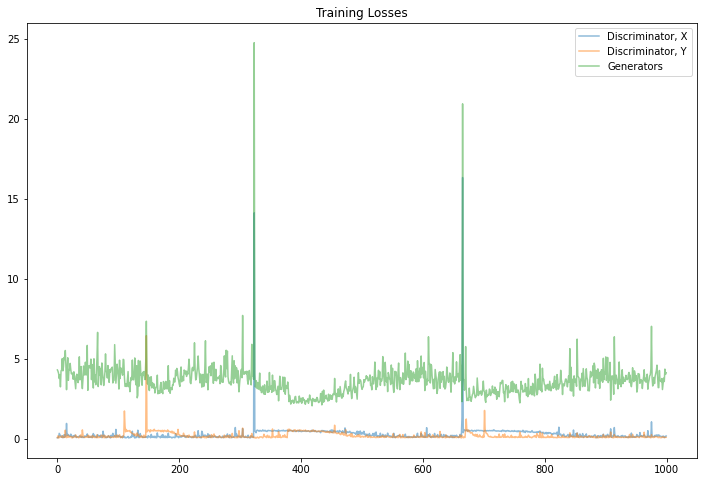

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [44]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


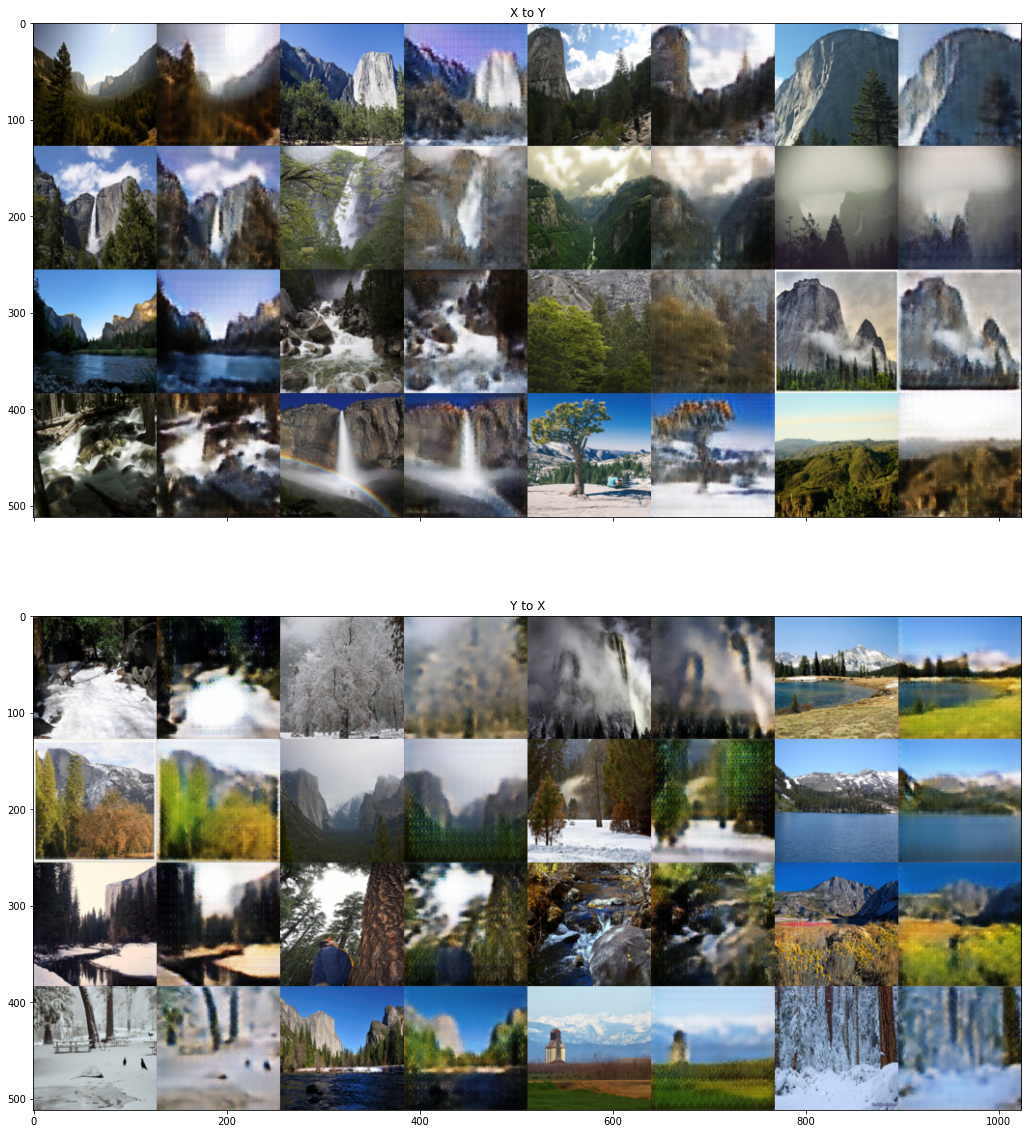

In [38]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

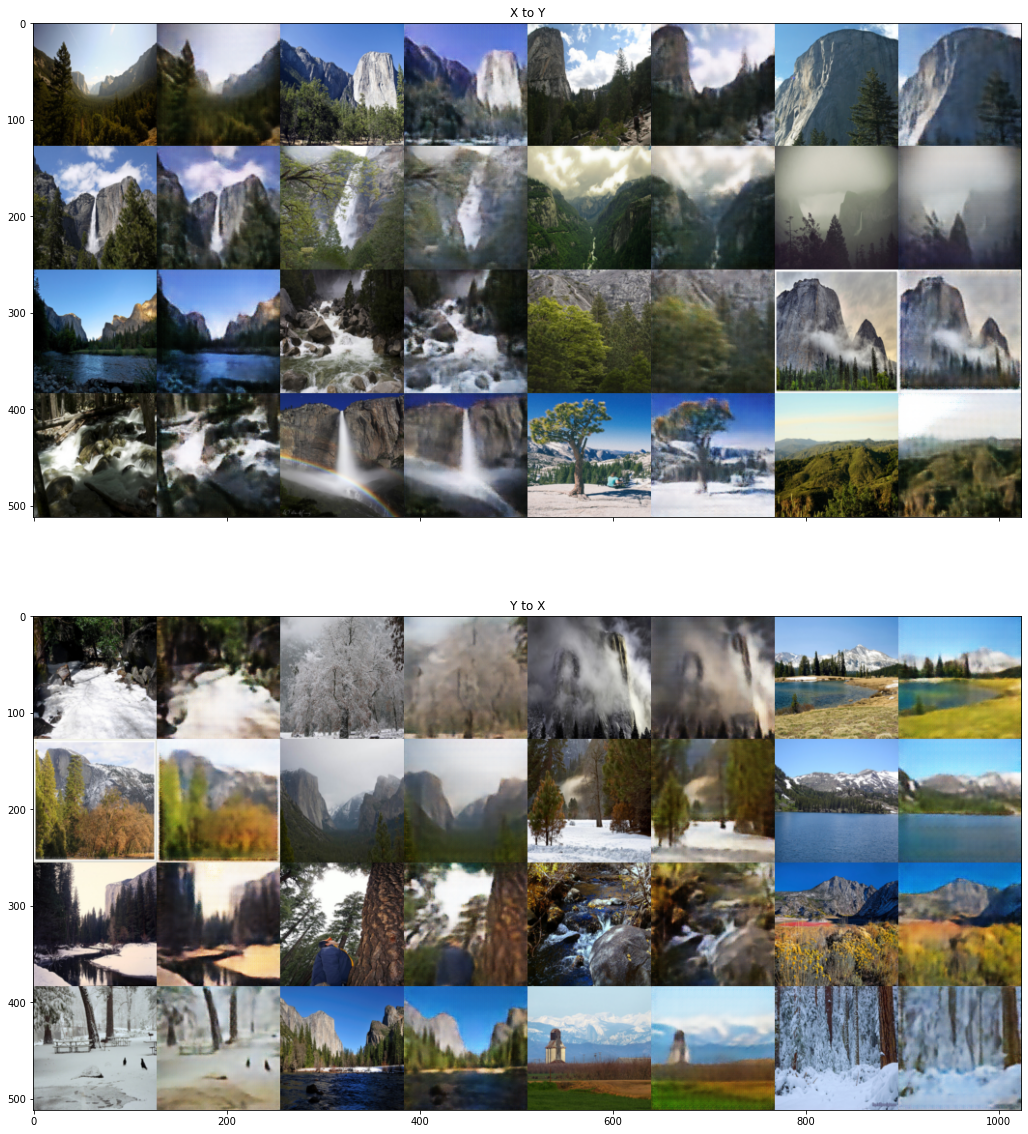

In [45]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

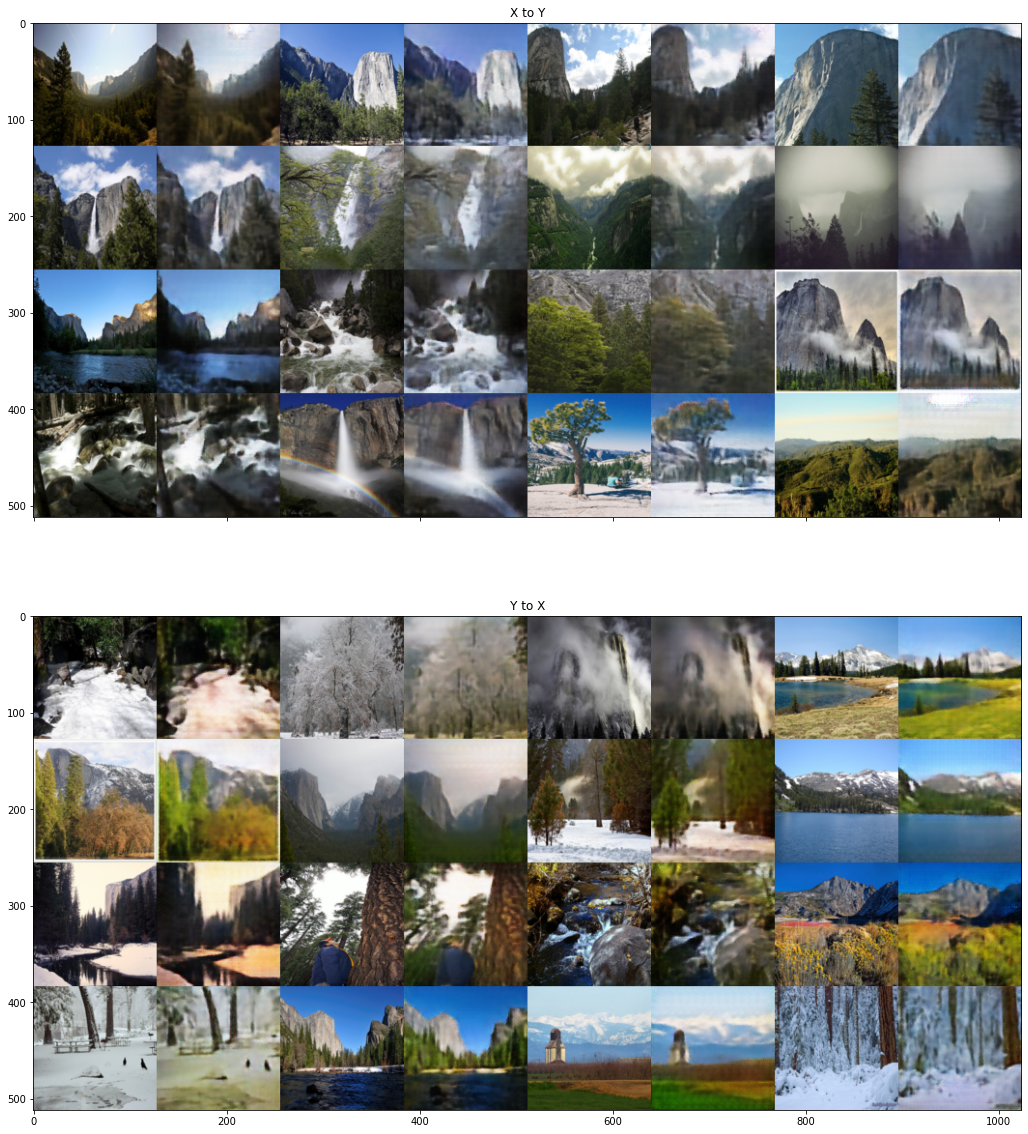

In [46]:
# view samples at iteration 1000
view_samples(5000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.